In [2]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [4]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [5]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [6]:
# Problem 3(a).
# TODO: coordinate descent of lasso, note lmda stands for lambda
#def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
    #########TODO##########
   # return (w,w0)

def loss(X, y, w, w0, lmda):
    a = (np.linalg.norm((X @ w) + w0 - y) ** 2)/2
    b = lmda * np.linalg.norm(w, ord=1)
    return a + b 
def lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
 #########TODO##########
     w, _ = Initialw(X, y)
     n,m = X.shape
     losses = []
 
     iters = np.arange(max_iter)
     for i in iters:
         w_prev = np.copy(w)
         w0 = y.mean() - (X @ w).mean()
         losses.append(loss(X, y, w, w0, lmda))
         for k in range(m):
             X_k = X[:,k]
             y_pred = X @ w
             c_k = 2* (X_k.T @ (y - y_pred + w[k]*X_k))
             a_k = 2* (np.linalg.norm(X_k) ** 2)
 
             w[k] = (np.sign(c_k) * max(0, np.abs(c_k) - lmda)) / a_k
 
         if np.all(np.abs(w - w_prev) < epsilon):
             break
 
     if draw_curve:
        plt.plot(np.arange(i+1), losses)
        plt.title("Iterations vs Loss")
        plt.xlabel("Iterations")
        plt.ylabel("Lasso loss")
 
     return (w,w0)

In [7]:
# Problem 3(a): data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
#print(X)
#print(y)
#print(w_true)
#print(w0_true)
print("X: ", X)
print("X.shape: ", X.shape)
print("y: ", y)
print("y.shape: ", y.shape)
print("w_true: ", w_true)
print("w_true.shape: ", w_true.shape)
print("w0_true: ", w0_true)


X:  [[ 0.10430293 -0.55011253 -0.07271465 ...  0.9858945   0.9762621
   0.66088793]
 [-1.00421694 -0.98028568  1.04231343 ...  0.54423528 -0.12555319
   0.29833038]
 [-0.93920808 -0.88460697 -0.36846914 ...  1.13839265 -0.17706563
  -1.1040073 ]
 ...
 [ 0.22627269 -1.41473902 -1.38744153 ...  0.40629811  1.81803336
   0.57718998]
 [-0.87827944 -1.1588945  -0.20821426 ...  2.5616317   0.71706683
  -1.6834583 ]
 [ 1.18136184  0.97753967 -1.08284432 ... -0.26515022  1.70874717
   1.25566562]]
X.shape:  (50, 75)
y:  [ -2.94661658  -9.2469922   -6.61852337  -8.71813976  -2.77082316
 -21.16384608   2.47720978  -8.18425969  17.12490003  13.69805685
  27.11926075 -35.71631086 -11.85971212  18.6242186  -10.34229026
 -26.02528015 -38.1950294   19.8767635    0.46858206  -3.92985654
   8.35960867  22.22456719 -63.25244103  -7.14048583   8.24525032
  23.62138731 -28.79749873  -3.8576642   18.13970725  43.72678802
 -24.73981649  -8.27834954  40.86565523  32.20353774  -7.46417913
  -1.43551809 -33.98

[ 9.87701348 -9.72978372 -9.78533191  9.85809008 10.08126976  0.
 -0.          0.04990917 -0.         -0.         -0.         -0.02029786
  0.22101146 -0.          0.10649288 -0.          0.12528557  0.
 -0.         -0.          0.          0.01886022  0.01337888  0.01044934
  0.         -0.02632922 -0.          0.         -0.          0.
 -0.         -0.          0.          0.          0.08118375  0.
 -0.06709603 -0.         -0.         -0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.04079482 -0.          0.         -0.          0.25100621 -0.
 -0.01947527 -0.          0.          0.         -0.          0.
 -0.         -0.03668451  0.         -0.13301942  0.          0.
 -0.          0.          0.          0.         -0.         -0.05597532
 -0.          0.          0.        ]

Indices of zero weights :
 [ 5  6  8  9 10 13 15 17 18 19 20 24 26 27 28 29 30 31 32 33 35 37 38 39
 40 41 42 43 44 45 46 47 49 50 51 53 55 56 57 58 59 60 62

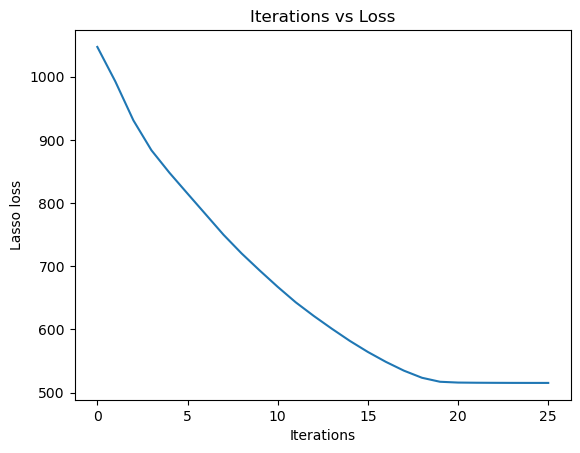

In [8]:
# Problem 3(a): run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso = lasso(X, y, lmda = 10.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
nonzero_weights_idx = np.arange(w_lasso.shape[0])[w_lasso == 0]
print("\nIndices of zero weights :\n", nonzero_weights_idx)
print("Number of zero weights: ", len(nonzero_weights_idx))

[ 9.53051744 -9.4689961  -9.47056747  9.4387061   9.58339615  0.
  0.          0.          0.         -0.         -0.         -0.
  0.          0.          0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.          0.
 -0.         -0.          0.         -0.         -0.          0.
 -0.         -0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.         -0.
  0.          0.          0.          0.         -0.         -0.
  0.         -0.          0.          0.          0.14519184 -0.
 -0.         -0.         -0.         -0.         -0.          0.
  0.         -0.         -0.         -0.          0.          0.
 -0.          0.          0.          0.         -0.         -0.
  0.          0.         -0.        ]

Indices of zero weights :
 [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 53
 54 55 5

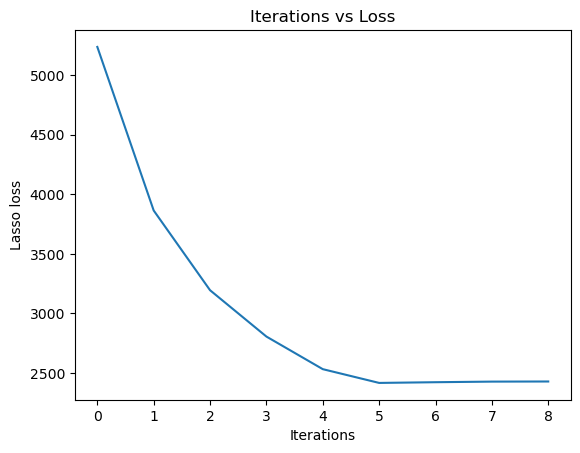

In [9]:
# Problem 3(a), trying another value for lambda
w_lasso, w0_lasso = lasso(X, y, lmda = 50.0, epsilon = 1.0e-2, draw_curve = True, max_iter = 100)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
nonzero_weights_idx = np.arange(w_lasso.shape[0])[w_lasso == 0]
print("\nIndices of zero weights :\n", nonzero_weights_idx)
print("Number of zero weights: ", len(nonzero_weights_idx))


In [10]:
# Problem 3(b):
# TODO: evaluation function of lasso model
def Evaluate(X, y, w, w0, w_true, w0_true):
 #########TODO##########
    n,m = X.shape
    w_idx = np.arange(m)
    sparsity_w = (w == 0).sum()
    num_nonzero_w = (w != 0).sum() # same as doing m-sparsity_w
    num_nonzero_w_true = (w_true != 0).sum()
    common_nonzero = np.intersect1d(w_idx[w != 0], w_idx[w_true != 0]).shape[0]
    precision_w = common_nonzero/num_nonzero_w
    recall_w = common_nonzero/num_nonzero_w_true
    rmse = np.linalg.norm((X @ w + w0) - y) / n
    return (rmse, sparsity_w, precision_w, recall_w)

In [11]:
# Problem 3(b)
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
#Emetric = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
#print(Emetric)

rmse, sparsity_w, precision_w, recall_w = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print(f" training rmse: {rmse:.4f}\n sparsity(of w): {sparsity_w}\n precision(of w): {precision_w:.4f}\n recall(of w):{recall_w}")


 training rmse: 0.1964
 sparsity(of w): 69
 precision(of w): 0.8333
 recall(of w):1.0


In [12]:
# Problem 3(c), first part
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot
#def LassoPath(w_lasso_arr, Lmdas):
 #########TODO##########
 #   colors = {0:"r", 1:"m", 2:"c", 3:"k", 4:"g"}
  #  plt.figure(figsize=(20,5), dpi=500)
   # num_lambdas = Lmdas.shape[0]
    #for i in np.arange(num_lambdas):
     #   if i in range(5): color = colors[i]
      #  else: color = "y"
       # plt.plot(Lmdas, w_lasso_arr[:,i], color=color, alpha=0.5);
    #plt.xlabel("Lasso regularization coefficient (lambda)")
    #plt.ylabel("Weight coefficient")
    #return


Regularization coefficient will be varied in the range 0 to 481.33514886367266


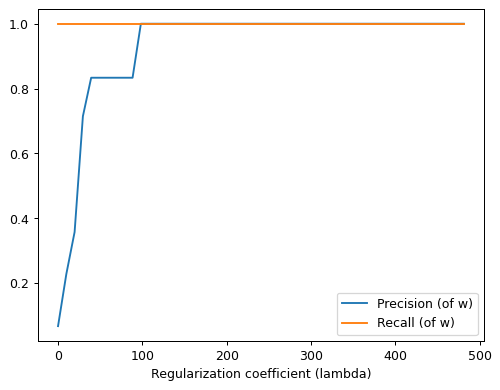

In [13]:
# Problem 3(c), second part:
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, w_true, w0_true, Lmdas, graph=True):
 #########TODO##########
     precision_w_list, recall_w_list, w_lasso_list = [], [], []
     for lmda in Lmdas:
         w_lasso, w0_lasso = lasso(X, y, lmda = lmda, epsilon = 1.0e-2, draw_curve = False, max_iter = 100)
         w_lasso_list.append(w_lasso)
         rmse, sparsity_w, precision_w, recall_w = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
         precision_w_list.append(precision_w)
         recall_w_list.append(recall_w)
     if graph:
         plt.figure(dpi=90)
         plt.plot(Lmdas, precision_w_list, label="Precision (of w)");
         plt.plot(Lmdas, recall_w_list, label="Recall (of w)");
         plt.xlabel("Regularization coefficient (lambda)");
         plt.legend()
     w_lasso_arr = np.vstack(w_lasso_list)
     return (precision_w_list, recall_w_list, Lmdas, w_lasso_arr)
starting_lmda = np.max((y - y.mean())@X)
ending_lmda = 0
print(f"Regularization coefficient will be varied in the range {ending_lmda} to {starting_lmda}")
Lmdas = np.linspace(starting_lmda, ending_lmda, 50)
_, _, Lmdas, w_lasso_arr = EvaluatePath(X, y, w_true, w0_true, Lmdas)

In [14]:
 def LassoPath(X, y, w_true, w0_true):
     starting_lmda = np.max((y - y.mean())@X)
     ending_lmda = 0
     print(f"Regularization coefficient will be varied in the range {ending_lmda} to {starting_lmda}")
     Lmdas = np.linspace(starting_lmda, ending_lmda, 50)
     precision_w_list, recall_w_list, Lmdas, w_lasso_arr = EvaluatePath(X, y, w_true, w0_true, Lmdas, graph=True)
     LassoPath(w_lasso_arr, Lmdas)
 # the smallest lambda that gives the best precision and recall in case of ties. Remember that Lmdas is in descending order
     best_lmda_p, best_lmda_r = Lmdas[-np.argmax(precision_w_list[::-1]) - 1], Lmdas[-np.argmax(recall_w_list[::-1]) -1] 
     print(f"Best Precision (of nonzero w) = {max(precision_w_list)}, at lambda = {best_lmda_p}")
     print(f"Best Recall (of nonzero w) = {max(recall_w_list)}, at lambda = {best_lmda_r}")


Regularization coefficient will be varied in the range 0 to 481.33514886367266
Best Precision (of nonzero w) = 1.0, at lambda = 98.23166303340258
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


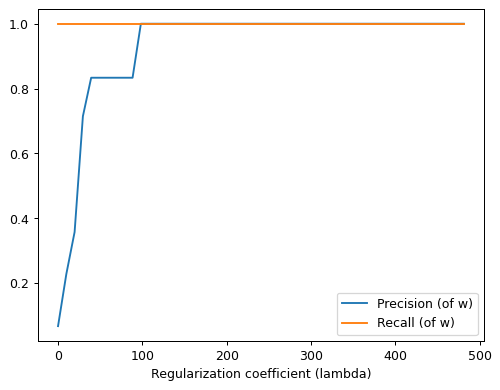

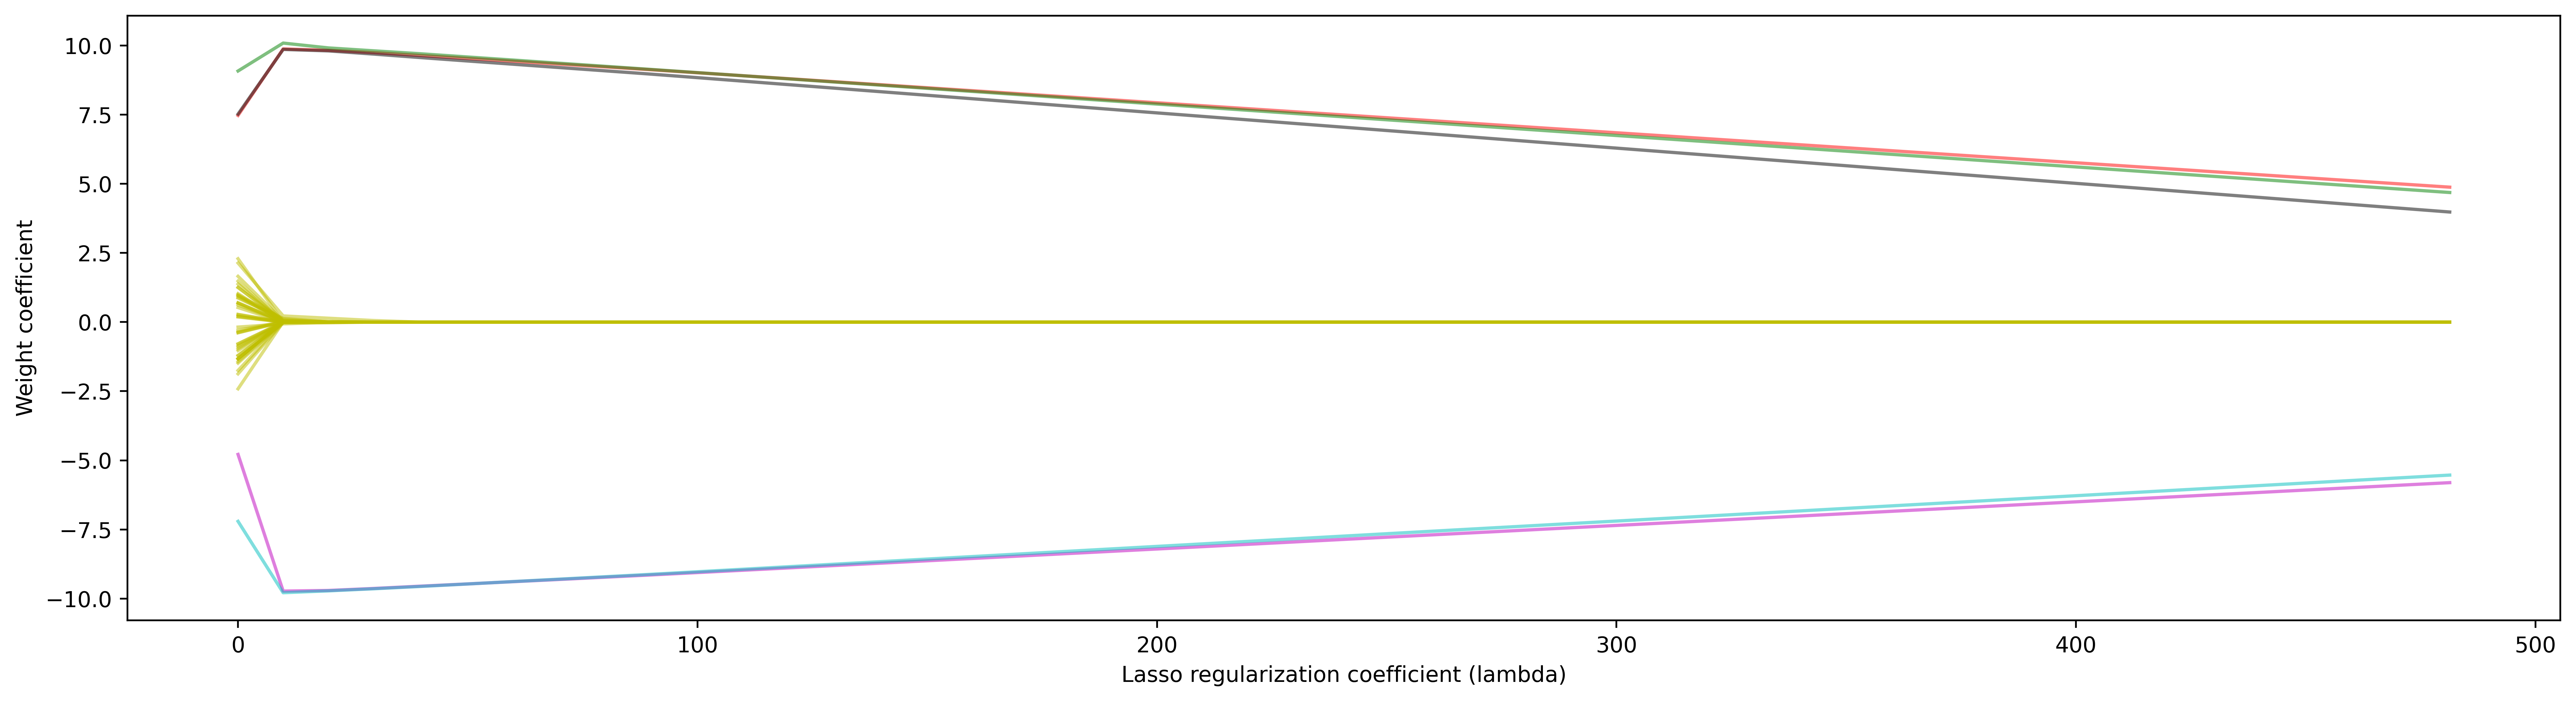

In [15]:
# Problem 3(c), third part:
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 516.311619169784
Best Precision (of nonzero w) = 0.8333333333333334, at lambda = 358.2570418729114
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


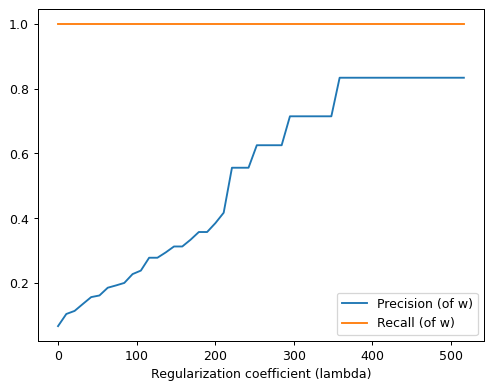

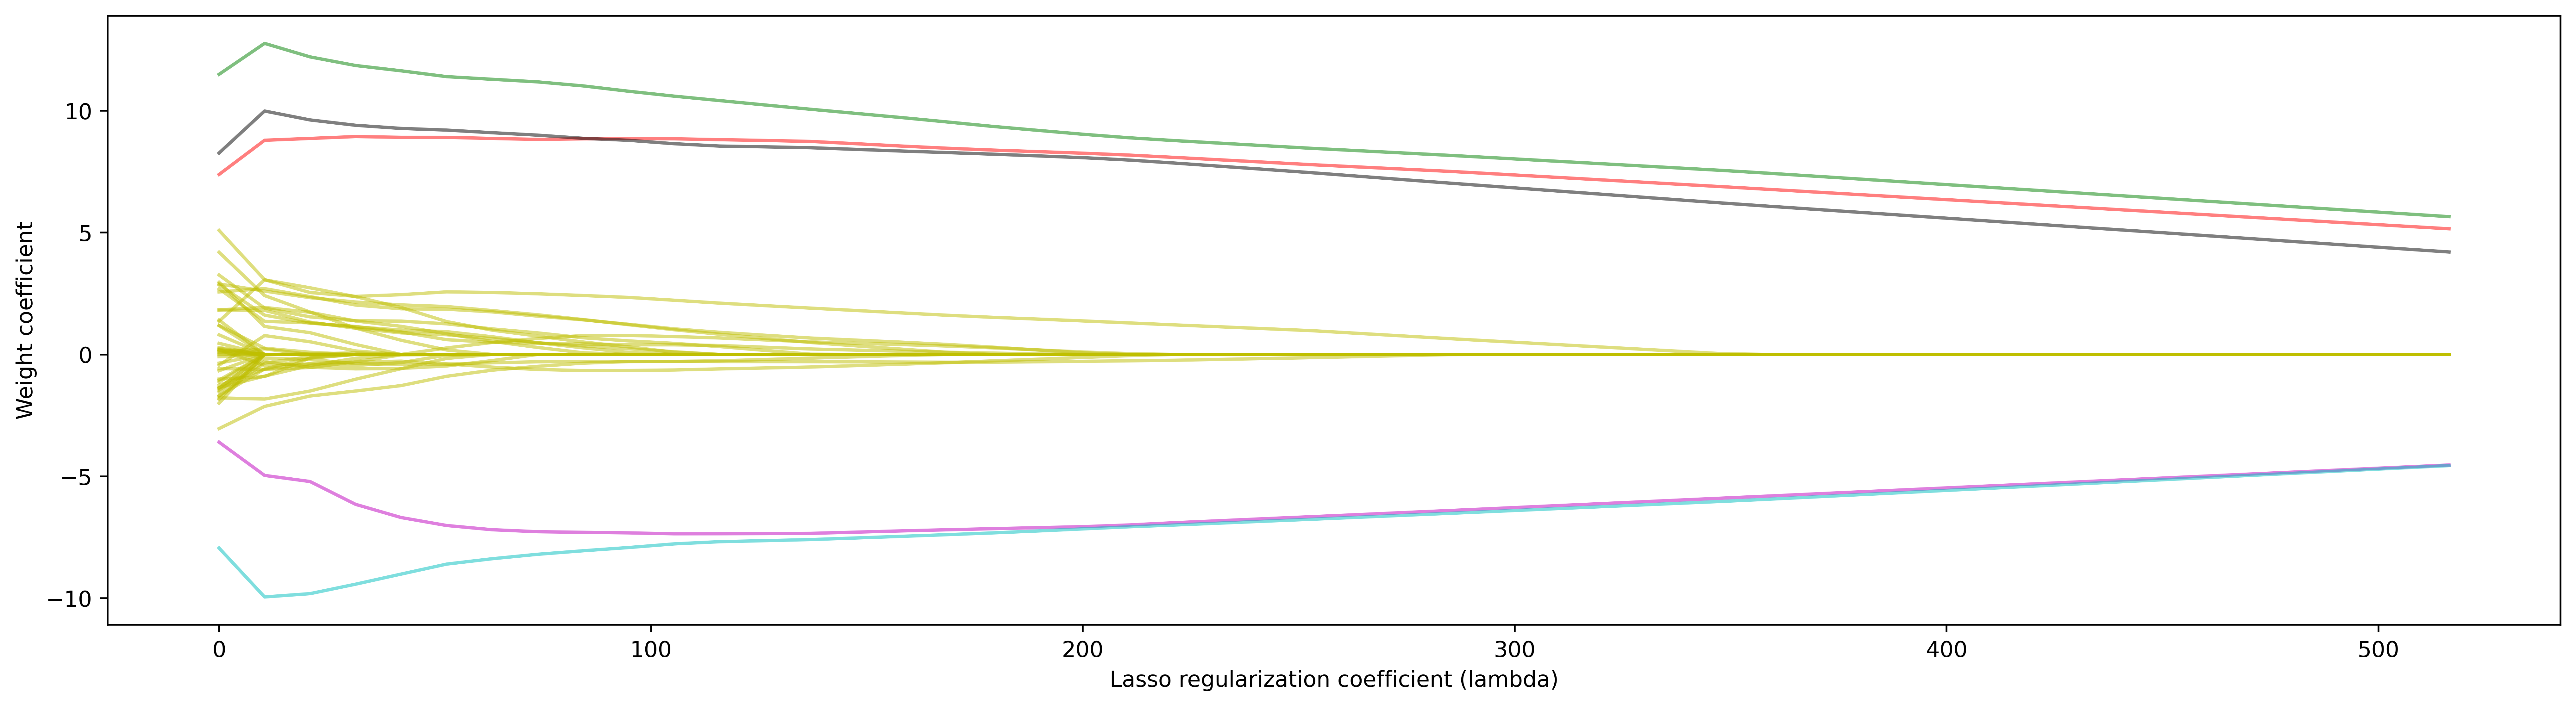

In [16]:
# Problem 3(c), noise standard deviation:
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 882.7716069524537
Best Precision (of nonzero w) = 1.0, at lambda = 54.04724124198697
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


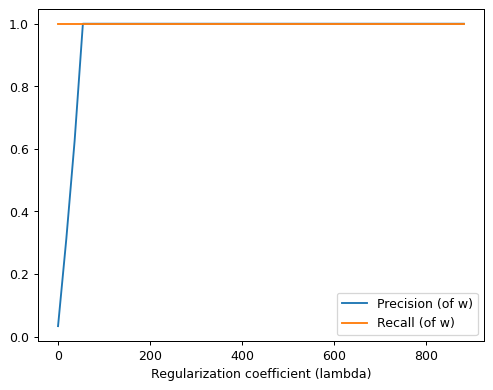

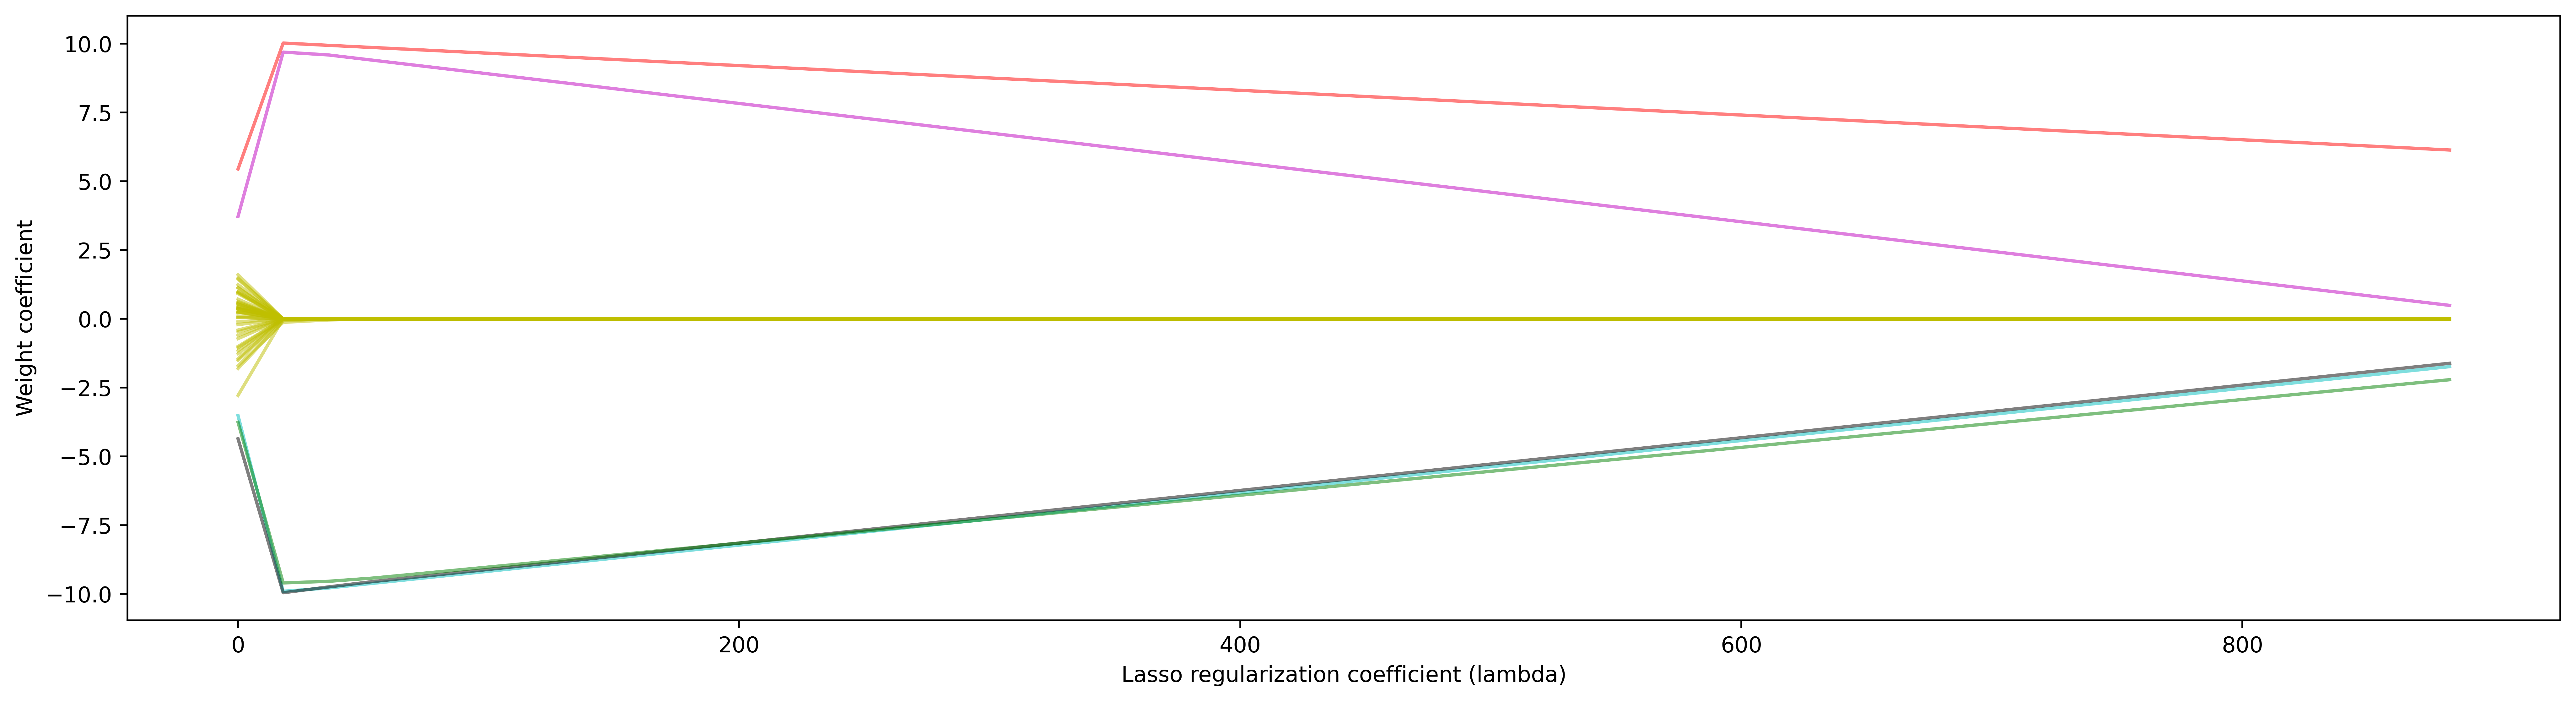

In [17]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 892.920587208855
Best Precision (of nonzero w) = 0.8333333333333334, at lambda = 437.34885904107176
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


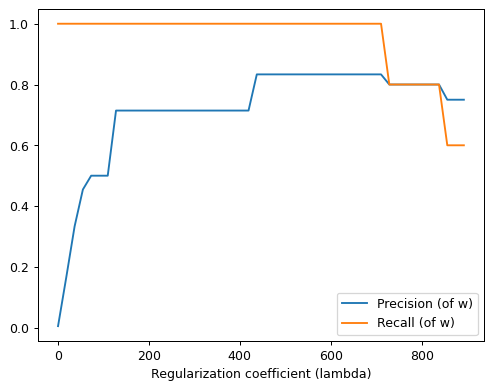

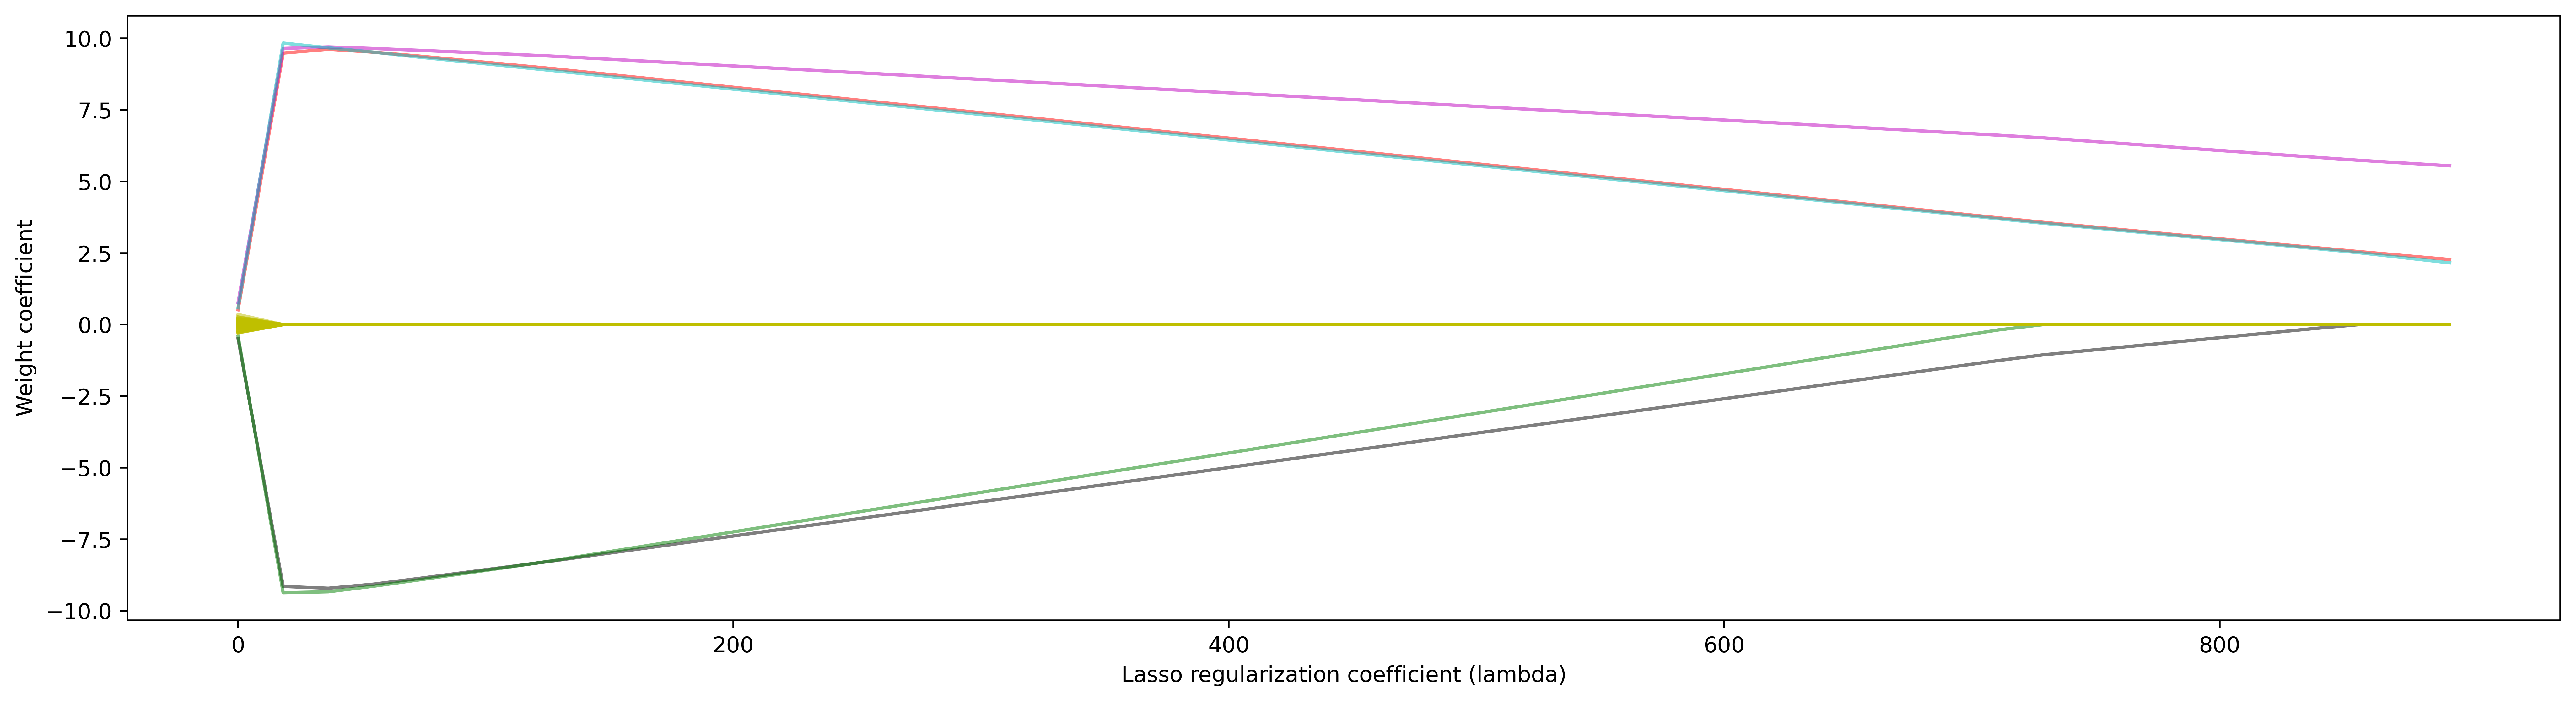

In [18]:
 # Problem 3(D), n=50, d=1000
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=1000, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)

Regularization coefficient will be varied in the range 0 to 1654.0274427016911


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


Best Precision (of nonzero w) = 1.0, at lambda = 67.51132419190594
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


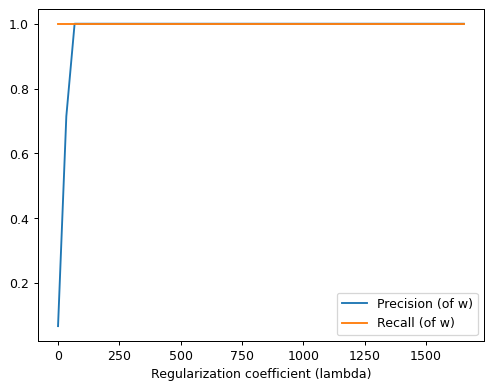

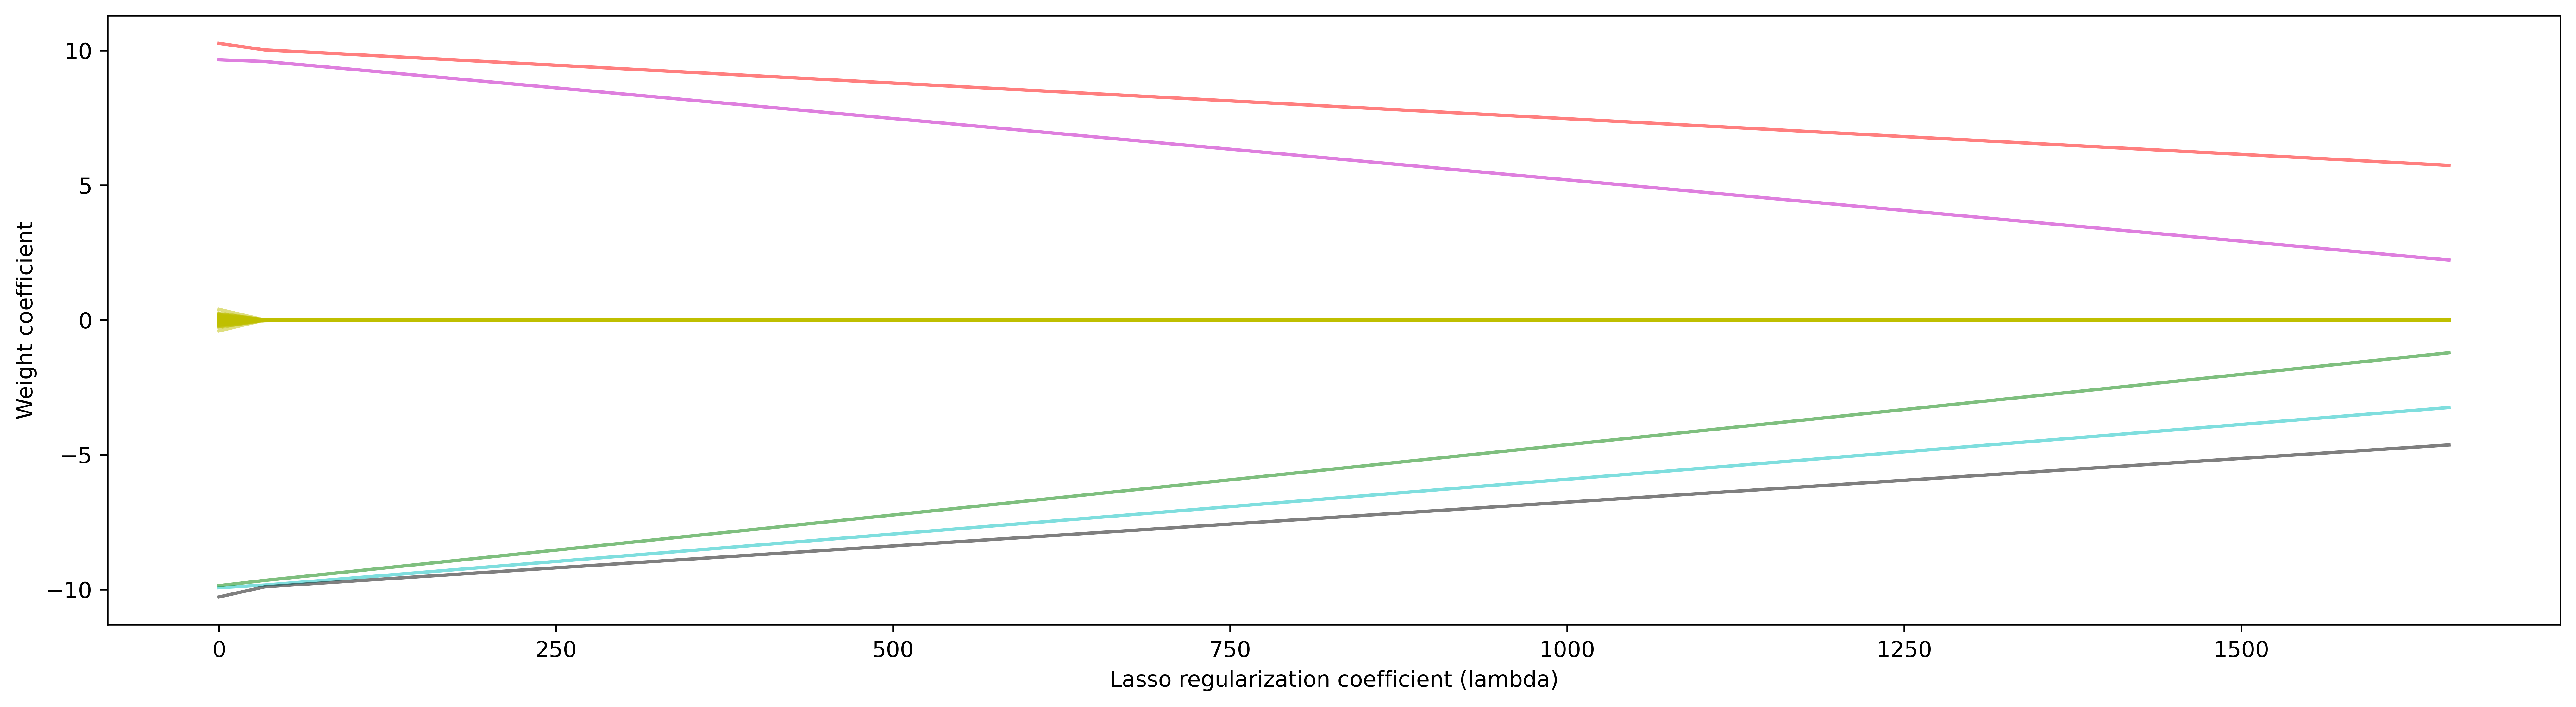

In [19]:
 # Problem 3(D), n=100, d=75
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=100, d=75, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 1020.1905839477948
Best Precision (of nonzero w) = 1.0, at lambda = 83.28086399573829
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


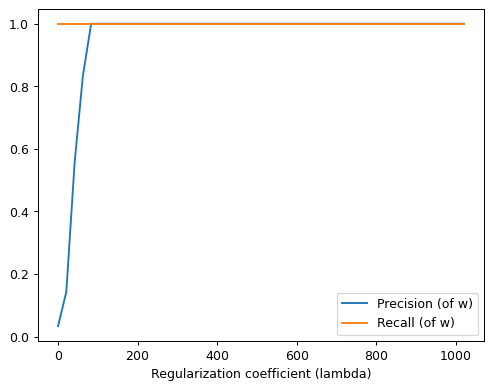

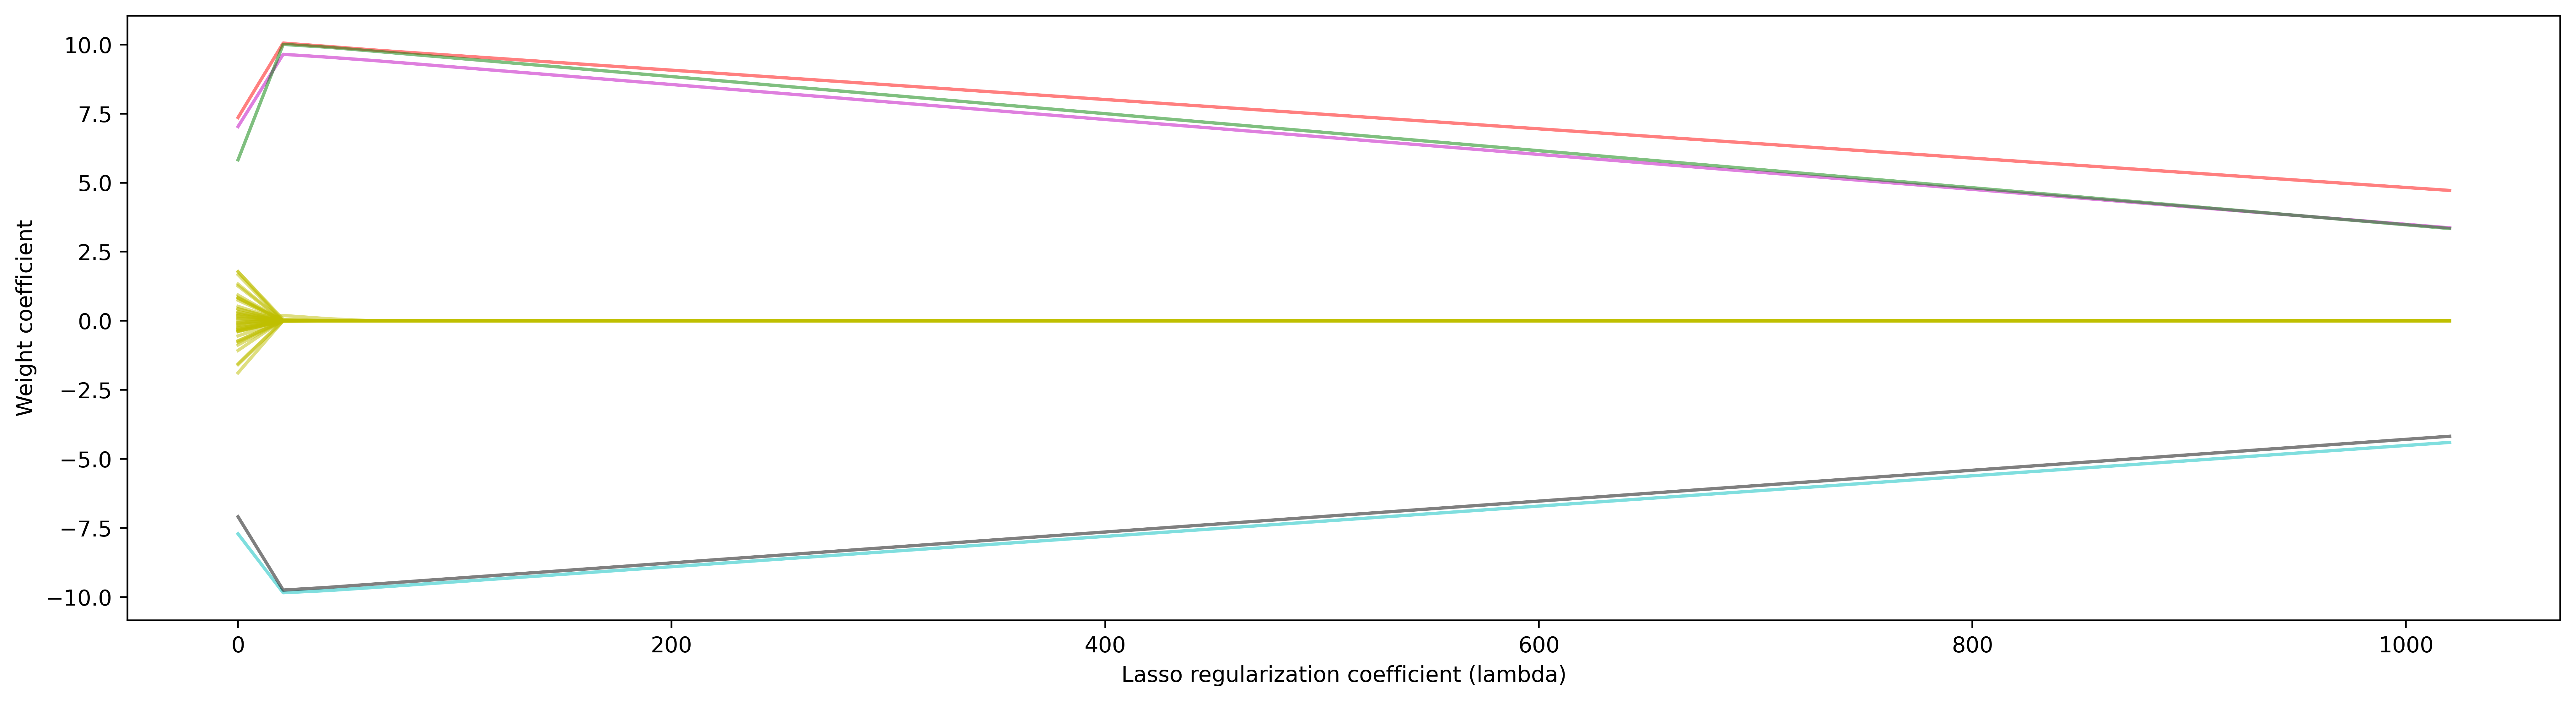

In [20]:
# Problem 3(D), n=100, d=150
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=100, d=150, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 1203.847337012853
Best Precision (of nonzero w) = 1.0, at lambda = 122.84156500131144
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


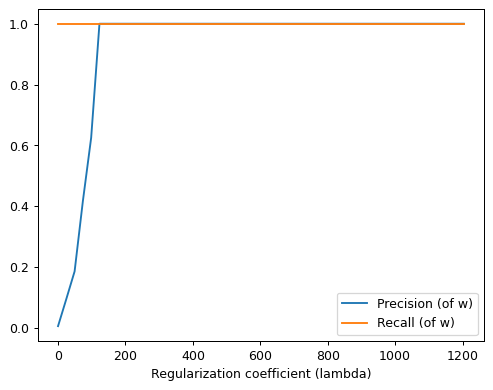

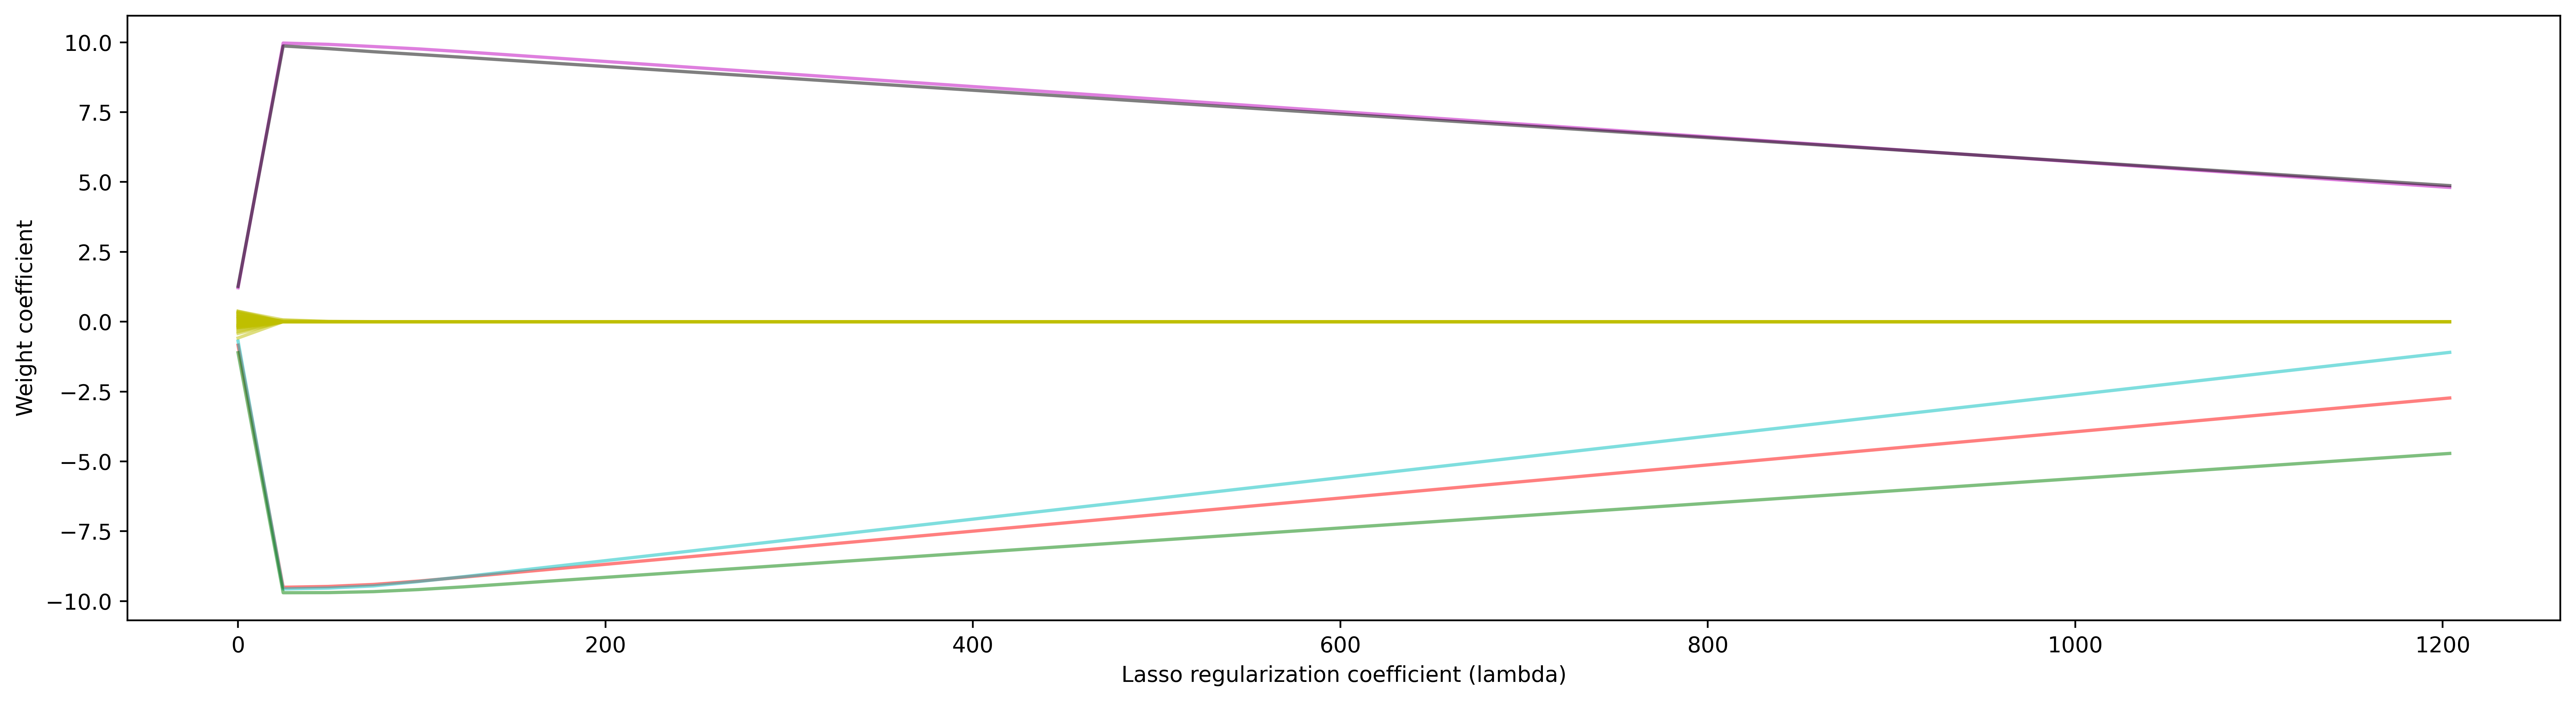

In [21]:
 # Problem 3(D), n=100, d=1000
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=100, d=1000, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 1402.4022752760422


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


Best Precision (of nonzero w) = 1.0, at lambda = 85.86136379241066
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


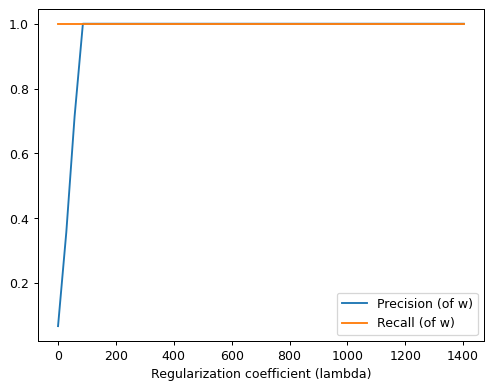

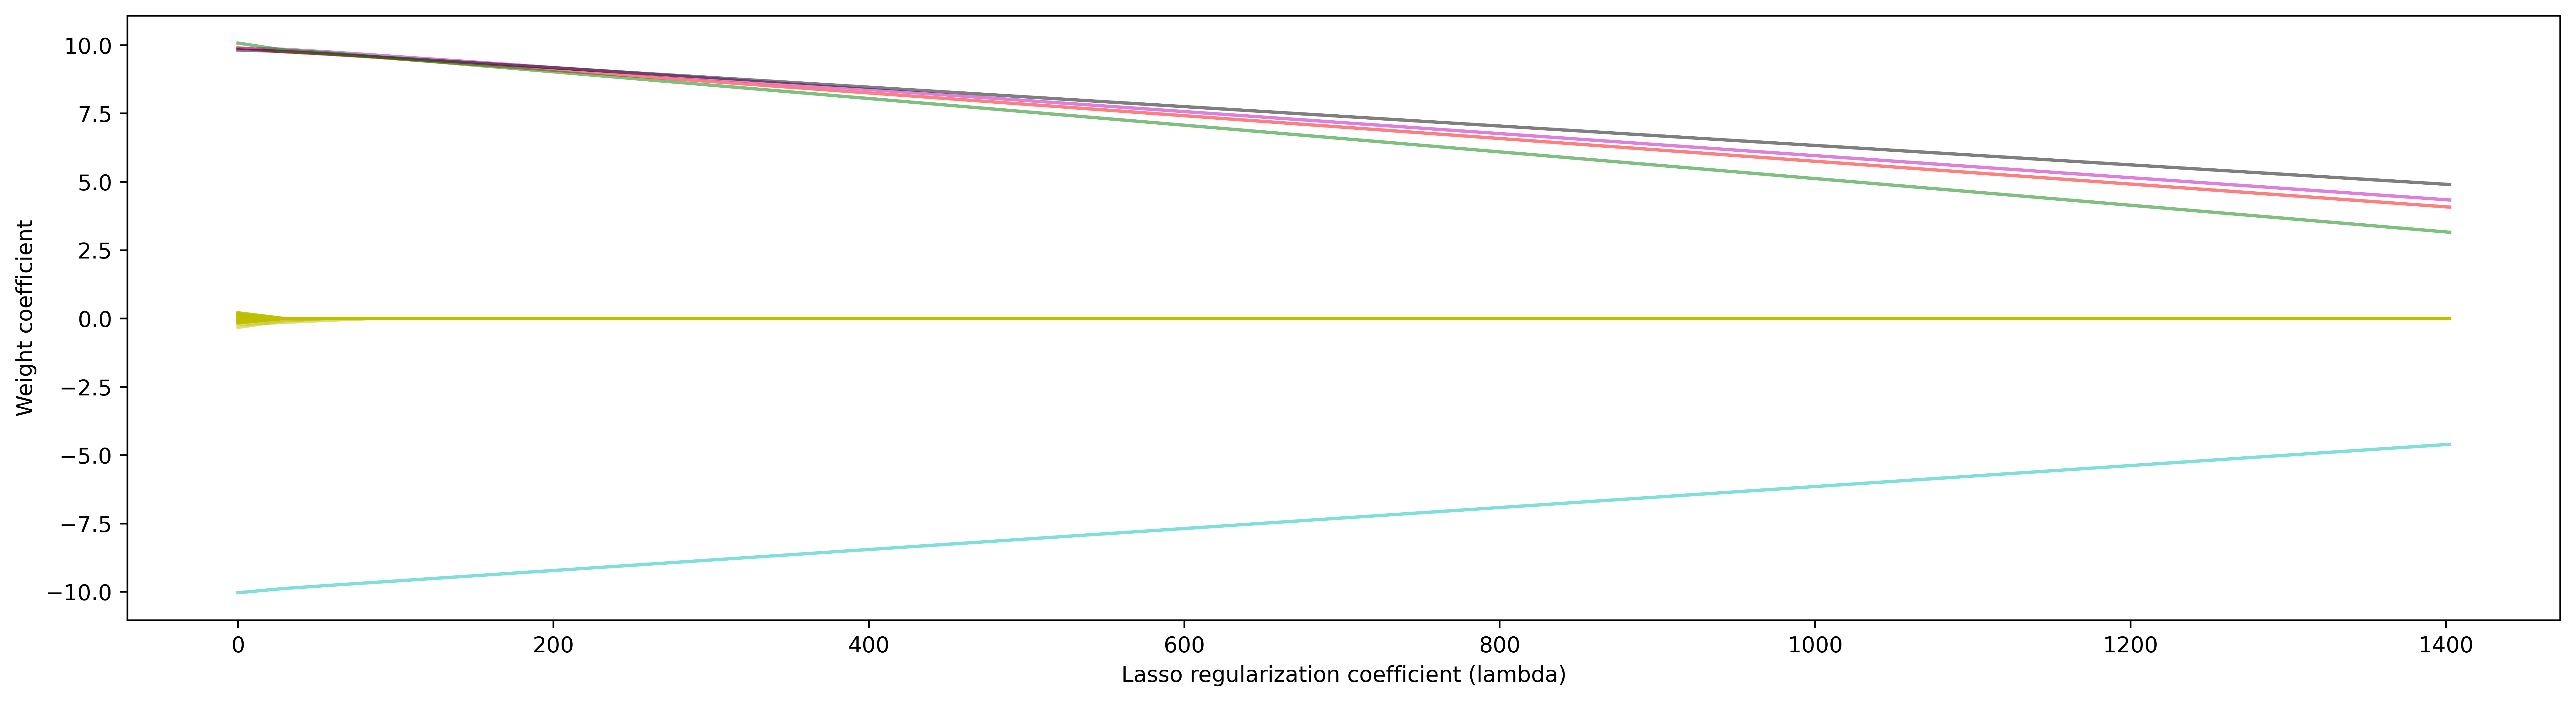

In [22]:
# Problem 3(d), n=150, d=75
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=150, d=75, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)

Regularization coefficient will be varied in the range 0 to 1809.5739065582288


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


Best Precision (of nonzero w) = 1.0, at lambda = 147.7203189027125
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


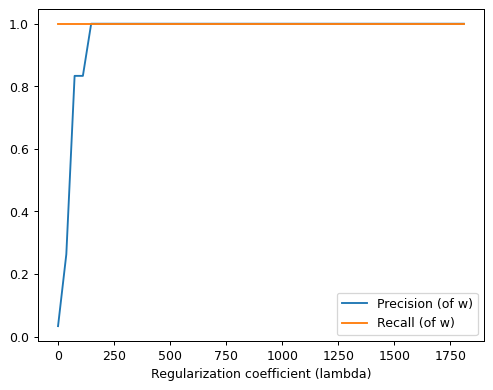

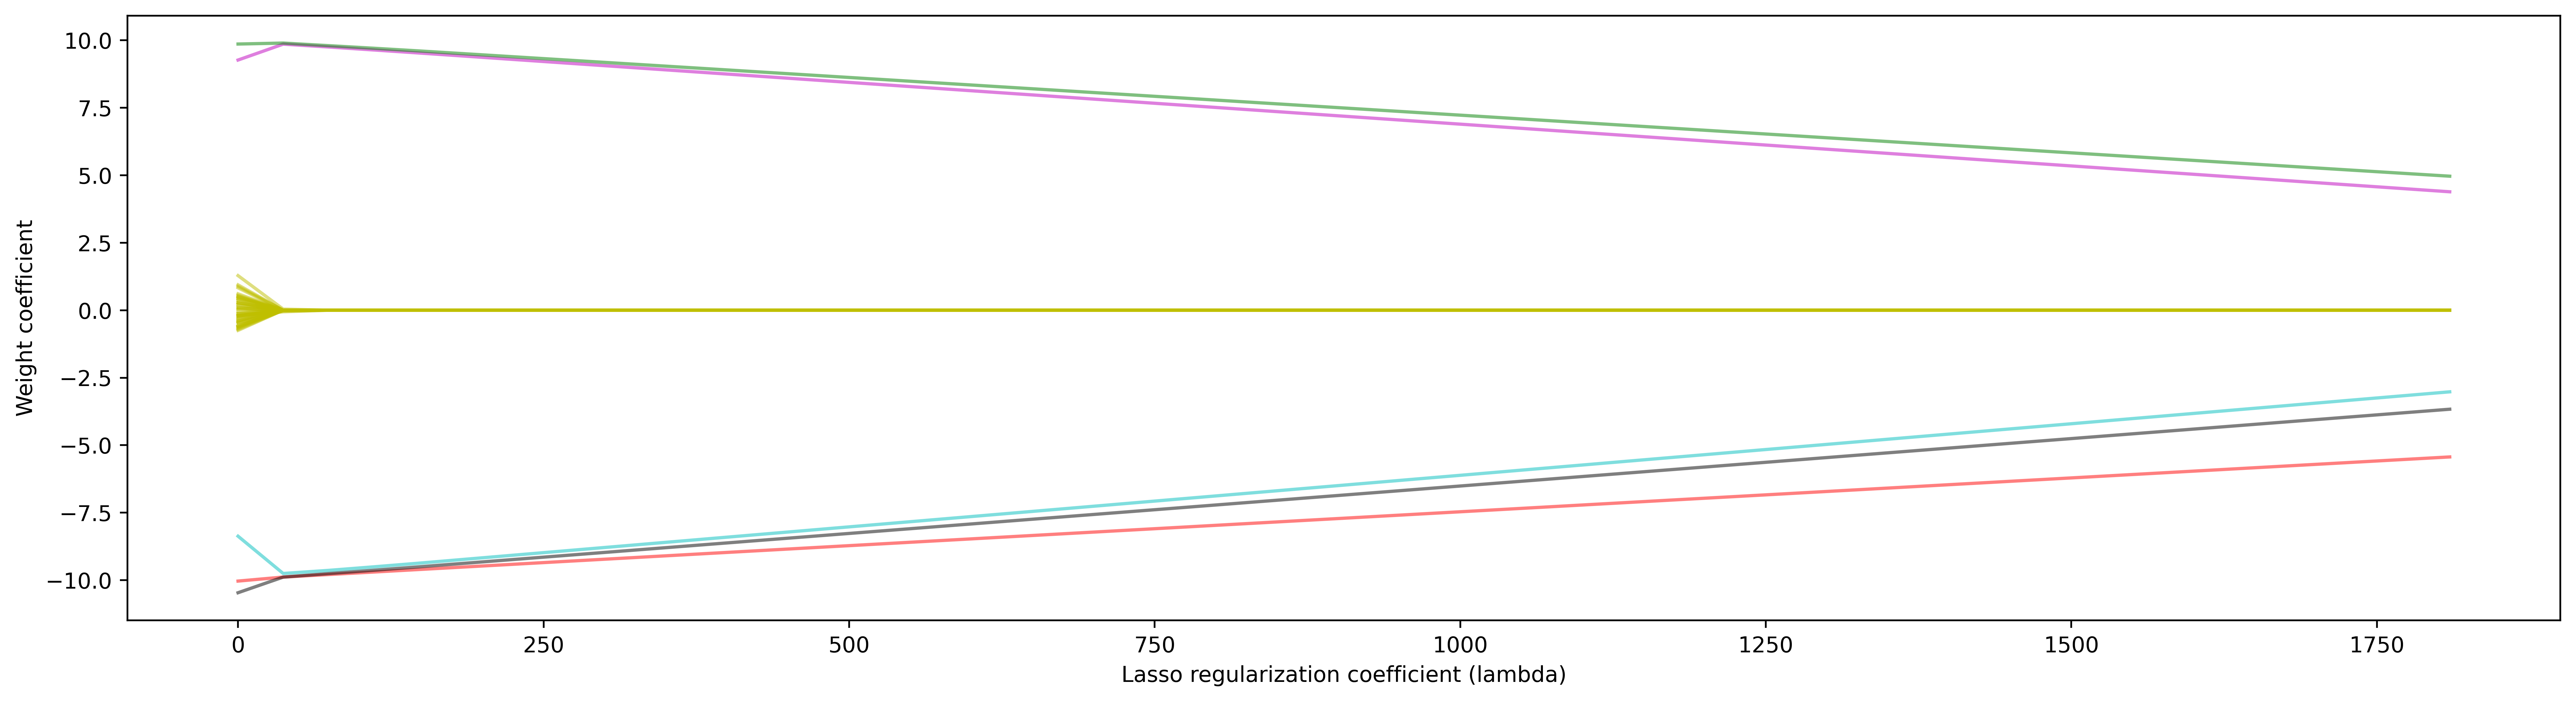

In [23]:
#Problem 3(d), n=150, d=150
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=150, d=150, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 1313.2691178631724
Best Precision (of nonzero w) = 1.0, at lambda = 187.60987398045313
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


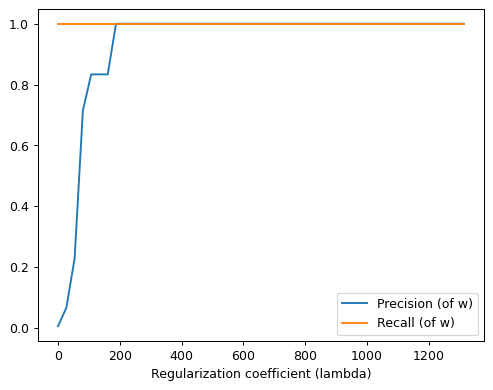

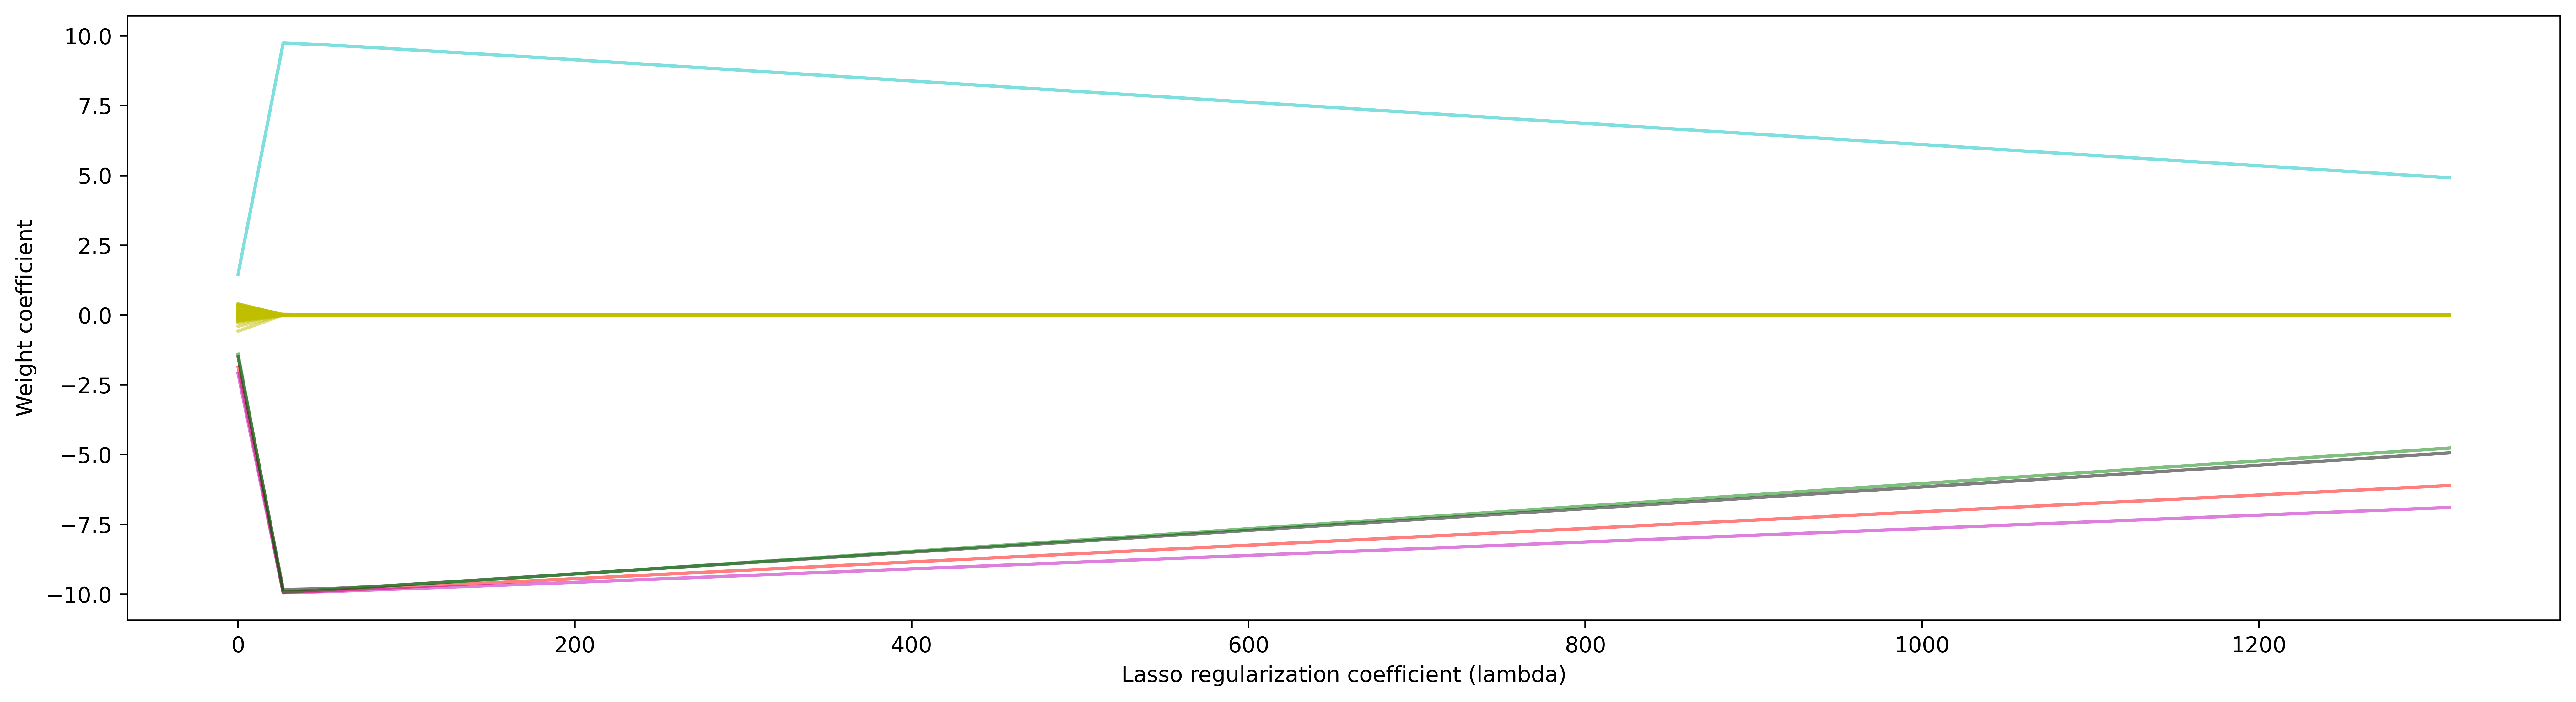

In [24]:
 # Problem 3(d), n=150, d=1000
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=150, d=1000, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)

Regularization coefficient will be varied in the range 0 to 9141.937716983564


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


Best Precision (of nonzero w) = 1.0, at lambda = 186.57015748946105
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


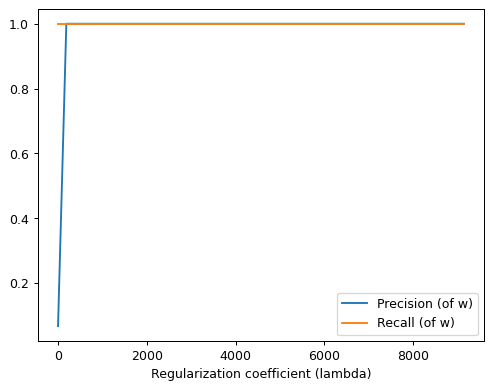

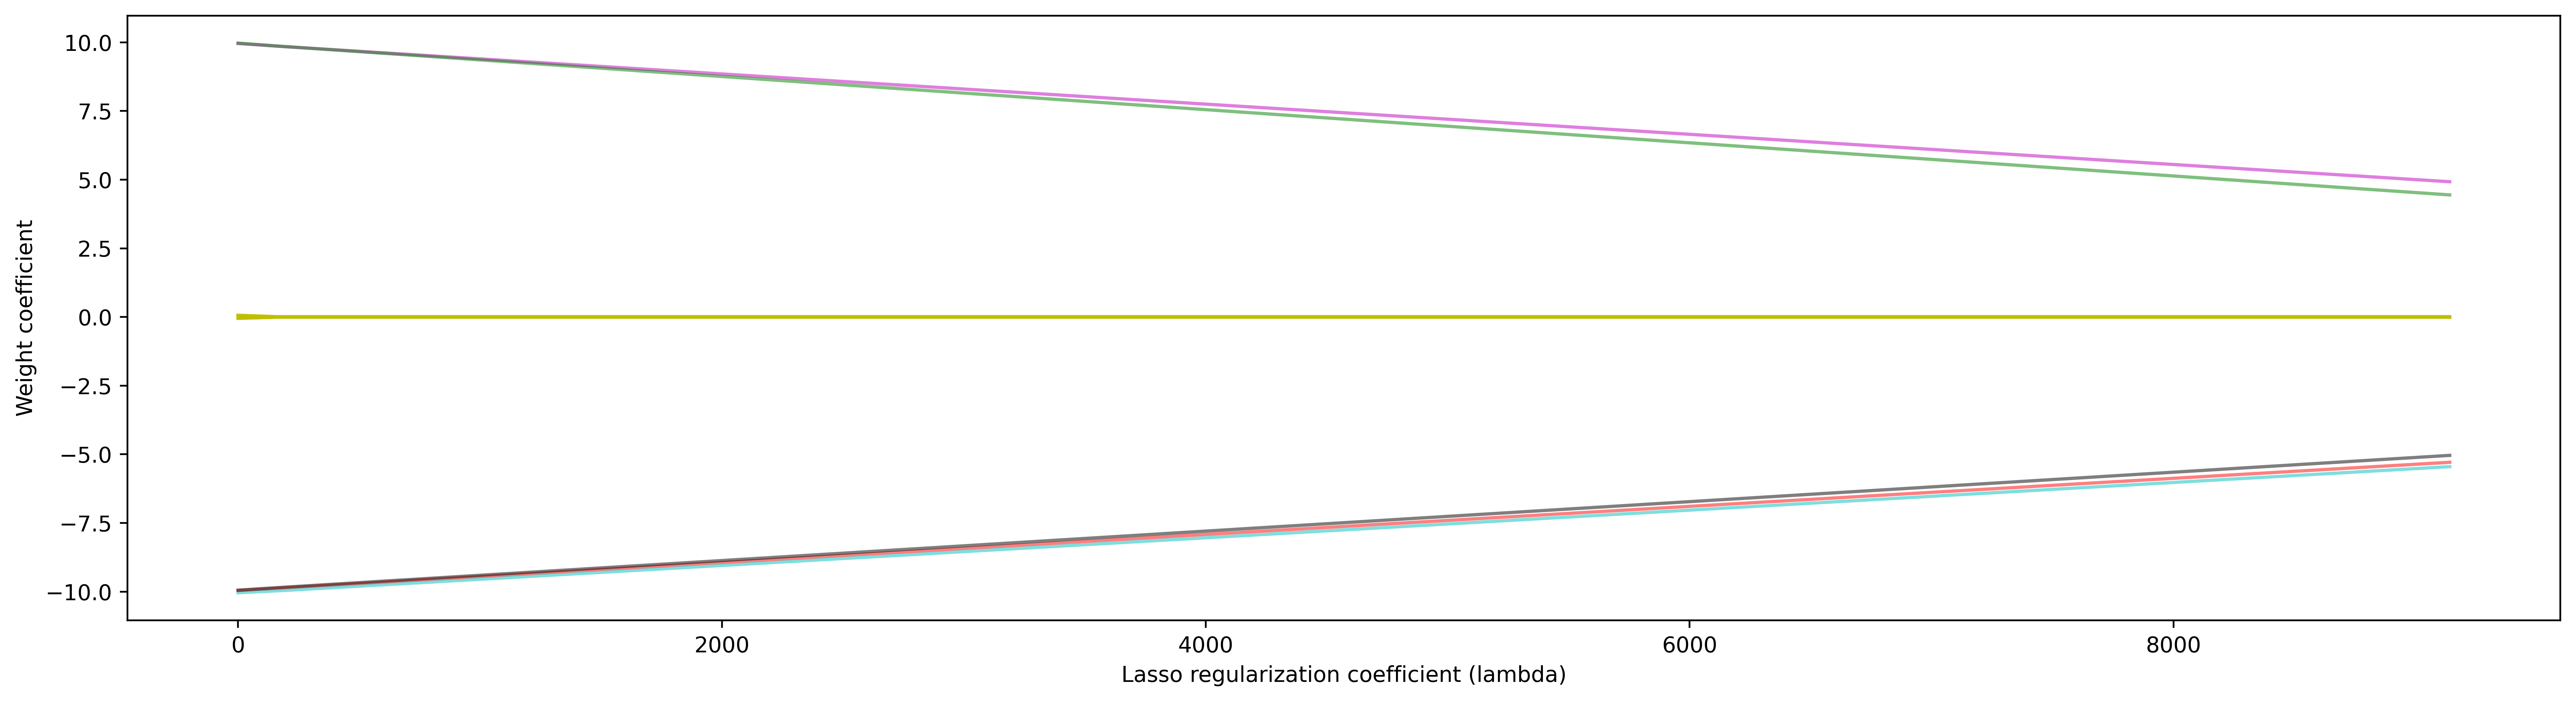

In [25]:
# Problem 3(d), n=1000, d=75
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=1000, d=75, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


Regularization coefficient will be varied in the range 0 to 9517.798676553304


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


Best Precision (of nonzero w) = 1.0, at lambda = 388.4815786348281
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


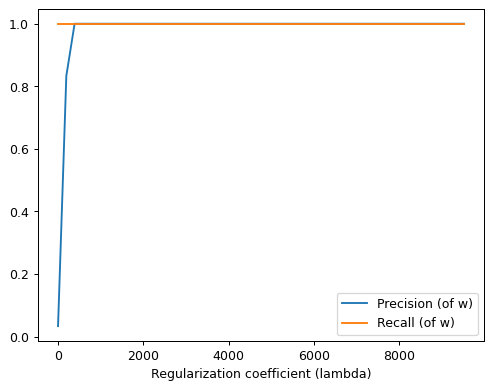

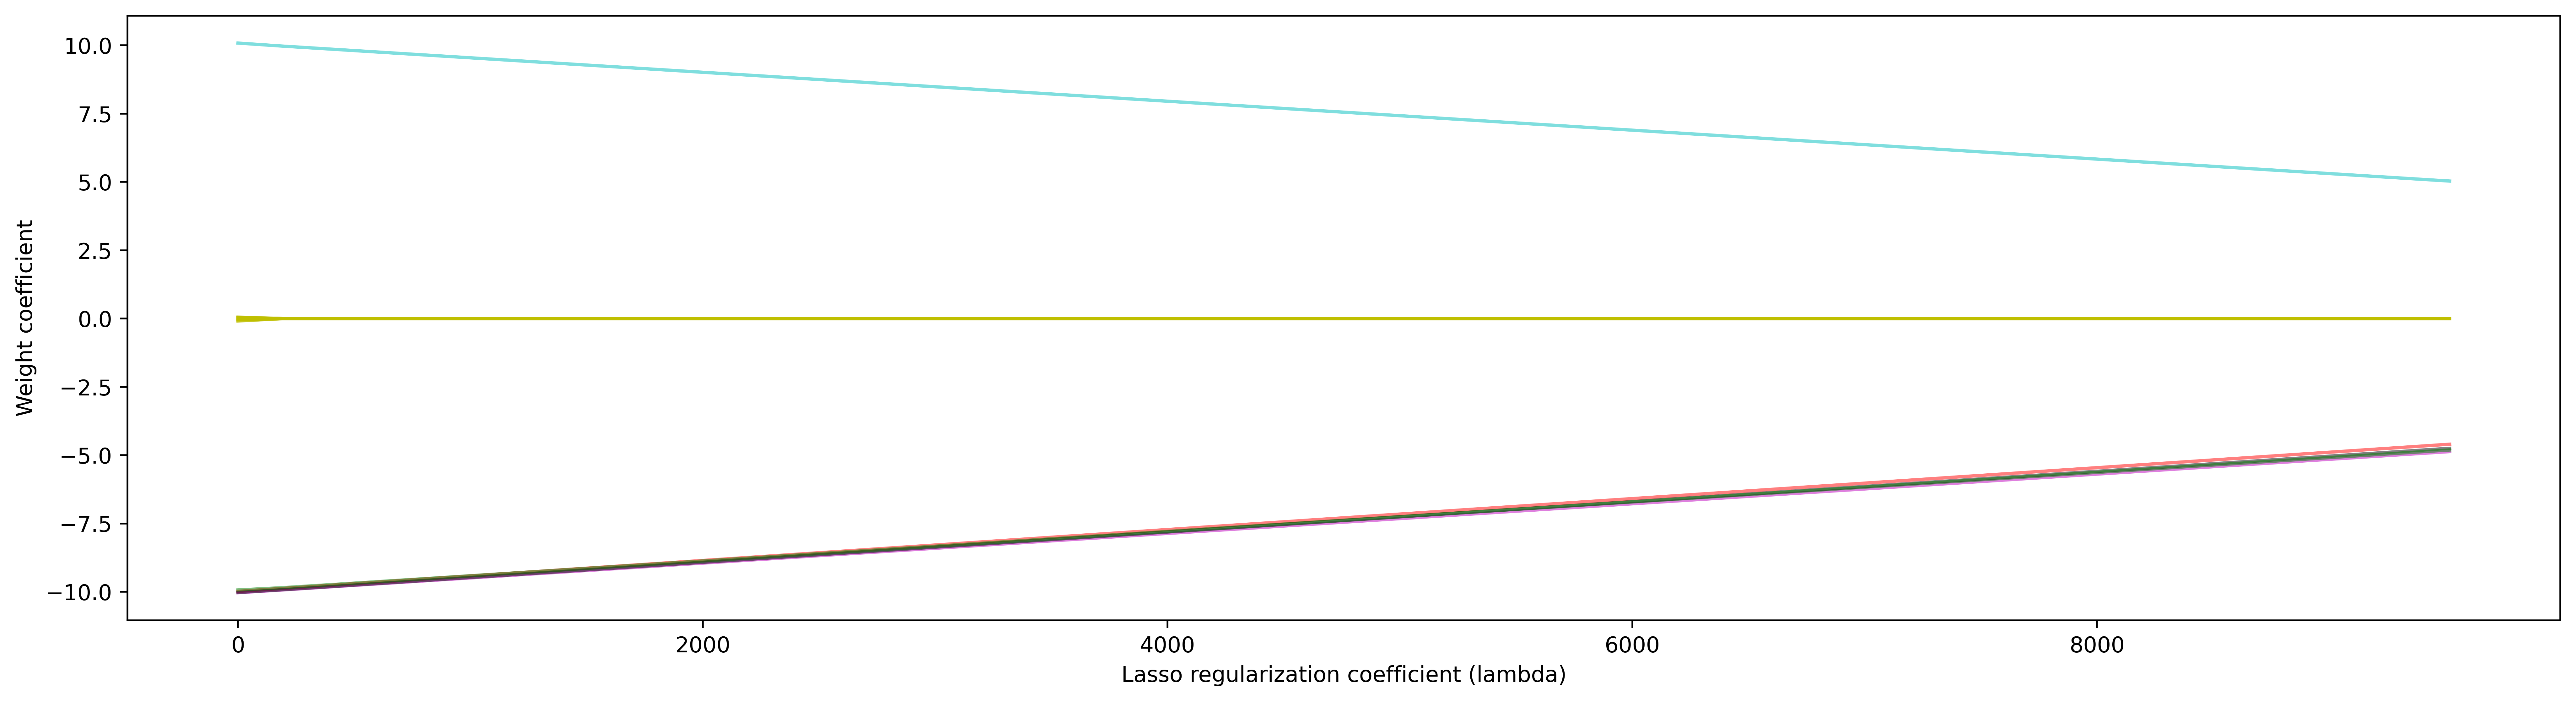

In [26]:
 # Problem 3(d), n=1000, d=150
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=1000, d=150, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)

Regularization coefficient will be varied in the range 0 to 11194.524720866515


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


Best Precision (of nonzero w) = 1.0, at lambda = 228.45968818095025
Best Recall (of nonzero w) = 1.0, at lambda = 0.0


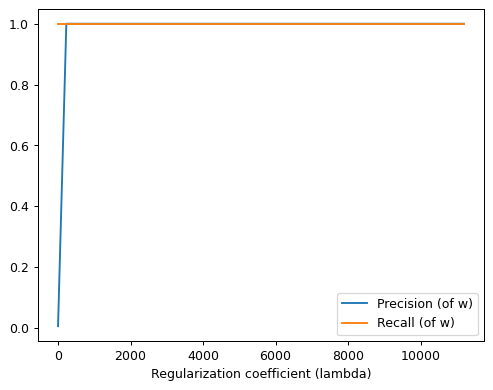

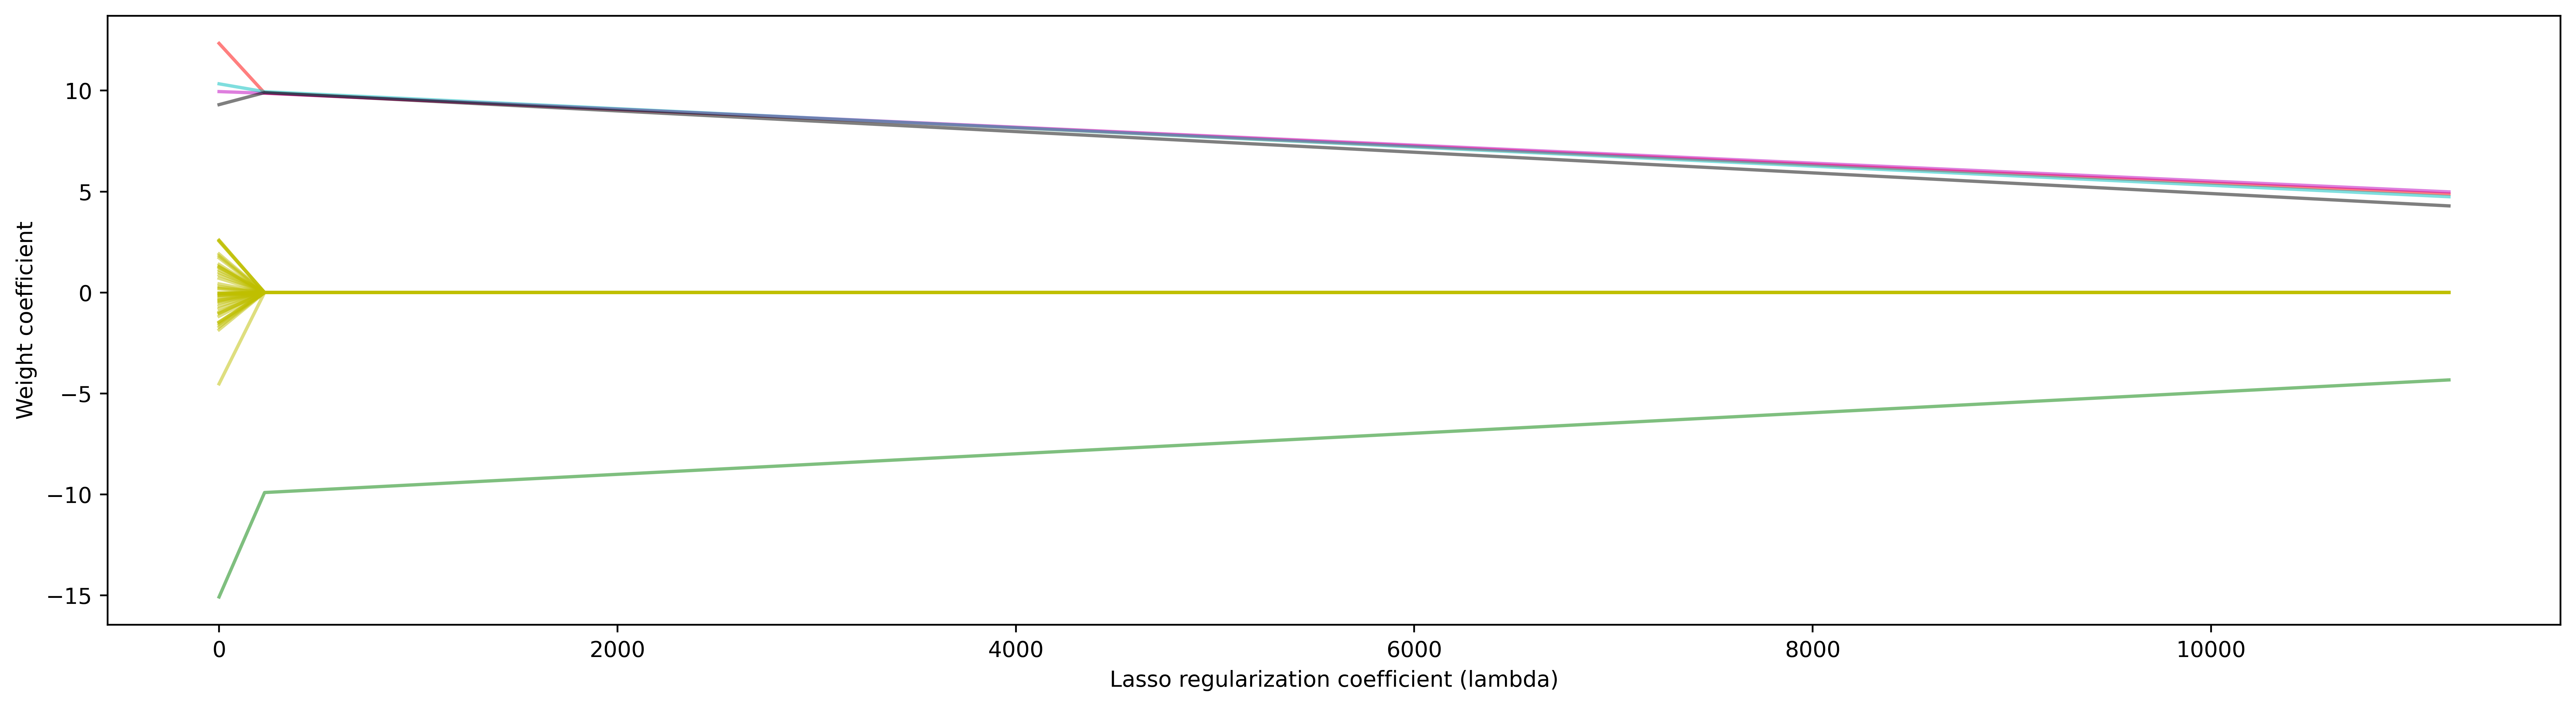

In [27]:
 # Problem 3(d), n=1000, d=1000
# TODO: try another 5 different choices of (n,d) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=1000, d=1000, k=5, sigma=1.0)
Evaluate_and_LassoPath(X, y, w_true, w0_true)


In [28]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx

In [29]:
# Problem 3(e): predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=np.int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)

In [30]:
# TODO: evaluation of your results
# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('./star_data.mtx', './star_labels.txt', './star_features.txt', 30000, 5000)


C:\Users\hvld06\AppData\Local\Temp\ipykernel_13136\908686032.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.loadtxt(yfile, dtype=np.int)


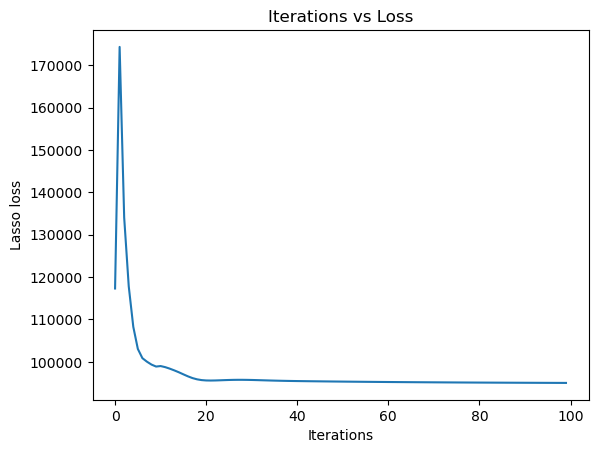

In [45]:
from scipy.sparse import csc_matrix

def loss(X, y, w, w0, lmda):
    a = (np.linalg.norm((X @ w) + w0 - y) ** 2)/2
    b = lmda * np.linalg.norm(w, ord=1)
    return a + b 
def lasso_csc(X, y, lmda = 10.0, epsilon = 1.0e-2, max_iter = 100, draw_curve = False):
 #########TODO##########
    w, w0 = Initialw(X, y)
    n,m = X.shape
    losses = []
    iters = np.arange(max_iter)
    for i in iters:
        w_prev = np.copy(w)
        w0 = y.mean() - (X @ w).mean()
        losses.append(loss(X, y, w, w0, lmda))
        for k in range(m):
            X_k = X[:,k]
            y_pred = X @ w
            c_k = 2* (X_k.T @ ((y - y_pred).reshape(-1,1) + w[k]*X_k))
            a_k = 2* (scipy.sparse.linalg.norm(X_k) ** 2)
 
            w[k] = (np.sign(c_k) * max(0, np.abs(c_k) - lmda)) / a_k
 
        if np.all(np.abs(w - w_prev) < epsilon):
            break
 
    if draw_curve:
       plt.plot(np.arange(i+1), losses)
       plt.title("Iterations vs Loss")
       plt.xlabel("Iterations")
       plt.ylabel("Lasso loss")
 
    return (w, w0)
w_optimal, w0_optimal = lasso_csc(X_train, y_train, lmda = 20.0, draw_curve = True)

Regularization coefficient will be varied in the range 3.169993276668704 to 31.699932766687038
** Lambda now is  31.699932766687038
** Lambda now is  30.198357004054493
** Lambda now is  28.69678124142195
** Lambda now is  27.195205478789404
** Lambda now is  25.693629716156863
** Lambda now is  24.19205395352432
** Lambda now is  22.690478190891774
** Lambda now is  21.188902428259233
** Lambda now is  19.687326665626685
** Lambda now is  18.185750902994144
** Lambda now is  16.6841751403616
** Lambda now is  15.182599377729055
** Lambda now is  13.68102361509651
** Lambda now is  12.179447852463966
** Lambda now is  10.677872089831425
** Lambda now is  9.17629632719888
** Lambda now is  7.674720564566336
** Lambda now is  6.173144801933791
** Lambda now is  4.671569039301247
** Lambda now is  3.169993276668704


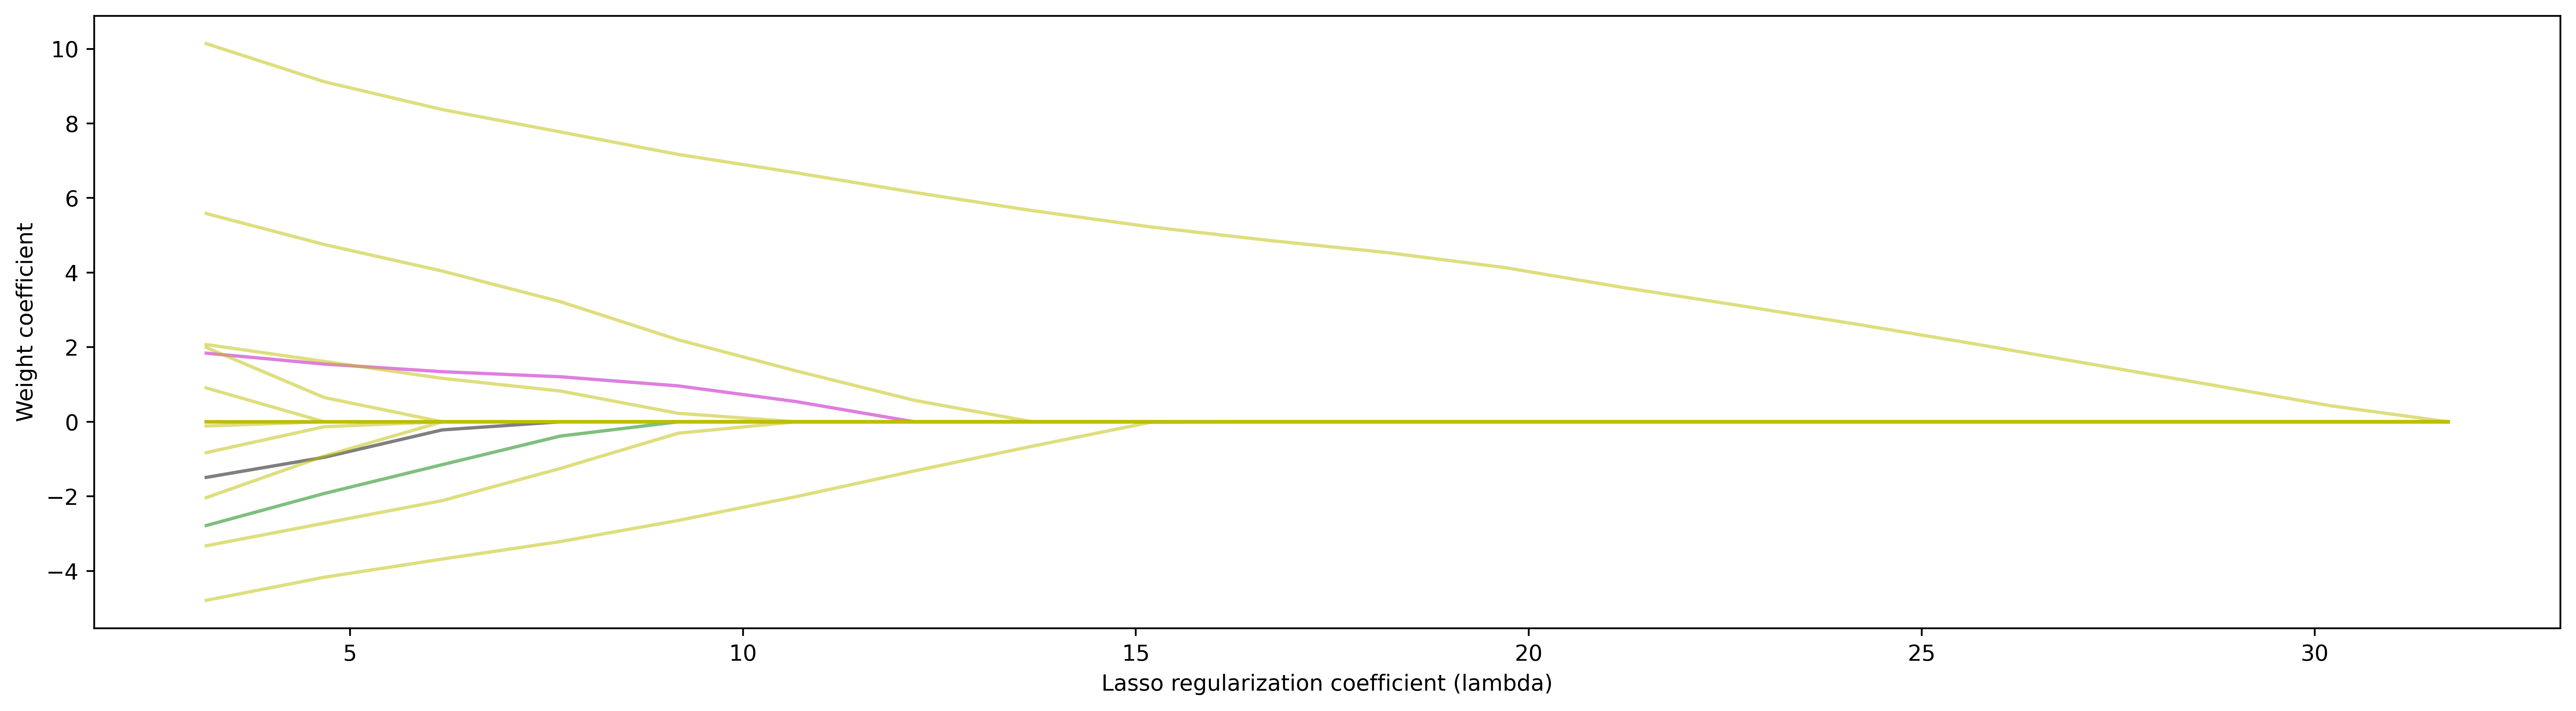

In [46]:
starting_lmda = np.max((y_train - y_train.mean()) @ X_train)
ending_lmda = 0.1 * starting_lmda
print(f"Regularization coefficient will be varied in the range {ending_lmda} to {starting_lmda}")
Lmdas = np.linspace(starting_lmda, ending_lmda, 20)
to_pickle = {}
rmse_train_list, rmse_test_list, w_lasso_list = [], [], []
for lmda in Lmdas:
    print("** Lambda now is ", lmda)
    w_optimal, w0_optimal = lasso_csc(X_train, y_train, lmda = lmda, draw_curve = False)
    w_lasso_list.append(w_optimal)
    rmse_train = np.linalg.norm((X_train @ w_optimal + w0_optimal) - y_train) / X_train.shape[0]
    rmse_test = np.linalg.norm((X_test @ w_optimal + w0_optimal) - y_test) / X_test.shape[0]
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    to_pickle[lmda] = [rmse_train_list, rmse_test_list, w_lasso_list]
    pickle.dump(to_pickle, open(f"lmda_{lmda}.p", "wb")) # saving the metrics
 
w_optimal_arr = np.vstack(w_lasso_list)
LassoPath(w_optimal_arr, Lmdas)

In [49]:
# Problem 3(e): predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
#def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
 #   return (w_lasso, w0_lasso, lmda_best)
#predicting reviews on yelp
rmse_valid_list = []
for lmda, w_optimal in zip(Lmdas, w_optimal_arr):
    w0_optimal = y_valid.mean() - (X_valid @ w_optimal).mean()
    rmse_valid = np.linalg.norm((X_valid @ w_optimal + w0_optimal) - y_valid) / X_valid.shape[0]
    rmse_valid_list.append(rmse_valid)

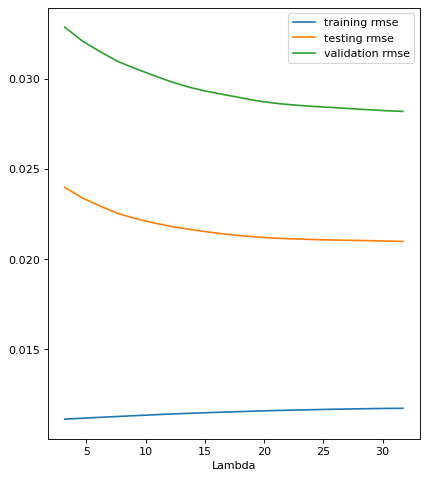

In [50]:
plt.figure(figsize=(6,7), dpi=80)
plt.plot(Lmdas, rmse_train_list, label="training rmse");
plt.plot(Lmdas, rmse_test_list, label="testing rmse");
plt.plot(Lmdas, rmse_valid_list, label="validation rmse")
plt.xlabel("Lambda");
plt.legend();

In [55]:
best_validation_idx = np.argmin(rmse_valid_list)
best_lmda_val = Lmdas[best_validation_idx]
print("validation rmse: ", best_lmda_val)
print(f"test rmse : {rmse_test_list[best_validation_idx]:.5f}", )
print("Best lambda value: ", best_lmda_val)


validation rmse:  31.699932766687038
test rmse : 0.02098
Best lambda value:  31.699932766687038


In [52]:
 # print the top-10 features you found by lasso
w_best_lasso = w_optimal_arr[best_validation_idx]
idx = (-np.abs(w_best_lasso)).argsort()[0:10]
print('Lasso select features:')
for i in range(10):
    print(f"{fName[idx[i]]},{np.abs(w_best_lasso[idx[i]])}")


Lasso select features:
and,223.22113289023784
the,150.84789204325796
sometime,80.23692410141189
great,75.07454644170079
sure the,59.21501152943644
the people,41.079960506924095
best,39.57700899439513
set,36.00499643169233
love,32.405586387707515
amazing,30.048314737518695
